In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df = pd.read_csv('train_1.csv')

In [3]:
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

> - Each row corresponds to a particular article and each column corresponds to a particular date.  
> - The values are the number of visits on that date.  
> - The page name contains data in this format: SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

In [4]:
import re
page_language = df.Page.apply(lambda row : row.split('wikipedia')[0][-3:-1])
df.insert(loc=1, column='language', value=page_language) 
df.language.unique()

array(['zh', 'fr', 'en', 'de', '02', 'ru', 'nt', ':P', 'ja', 'es'],
      dtype=object)

- zh - chinese, fr - french, en - english, de - german, ru - russian, ja - japanese, es - spanish. Rest are incorrect.

In [5]:
# Very less number of rows which has languages as 02 and :p. 
df[df.language == '02'].shape[0], df[df.language == ':P'].shape[0], df[df.language == 'nt'].shape[0]

(3, 1, 13551)

In [6]:
# dropping rows with '02' and ':P' as languages.
df = df[(df['language'] != '02') & (df['language'] != ':P')]
df.language.unique()

array(['zh', 'fr', 'en', 'de', 'ru', 'nt', 'ja', 'es'], dtype=object)

In [7]:
# All these webpages do not contain language codes and they are from mediawiki.org not wikipedia. 
# We can create a separate time series model for these pages with language code as 'na' or not applicable. 
df.language.replace(to_replace={'nt':'na'},inplace=True)
df.language.unique()

array(['zh', 'fr', 'en', 'de', 'ru', 'na', 'ja', 'es'], dtype=object)

In [8]:
# We have 2 request origins which are spider and browser agents.
access_origin = df.Page.apply(lambda row : row.split('_')[-1])
df.insert(loc=2, column='access_origin', value=access_origin) 
df.access_origin.unique()

array(['spider', 'all-agents'], dtype=object)

In [9]:
# The webpages can either be accessed by both mobile phones and computers or just one of these. 
access_type = df.Page.apply(lambda row : row.split('_')[-2])
df.insert(loc=3, column='access_type', value=access_type) 
df.access_type.unique()

array(['all-access', 'desktop', 'mobile-web'], dtype=object)

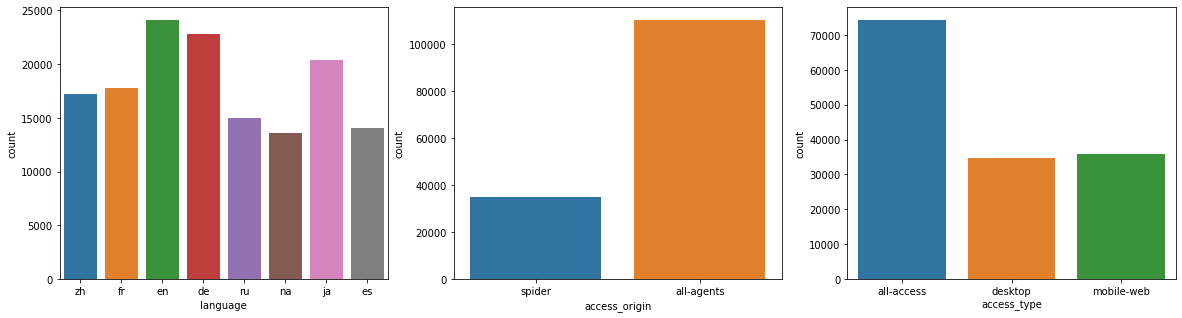

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.countplot(df.language)
plt.subplot(1,3,2)
sns.countplot(df.access_origin)
plt.subplot(1,3,3)
sns.countplot(df.access_type)
plt.show()

> Inference from the above plots
> - Most of the pages are in english language, followed by german and japanese.
> - User agents count is higher as compared to spider. 
> - All-access websites are higher in number as compared to desktop and mobile-web. 

In [11]:
# We have far too many domain names to feature engineer a new variable and conduct analysis.
# Hence, dropping page feature as most of the information is extracted.
df.drop('Page', axis=1, inplace=True)

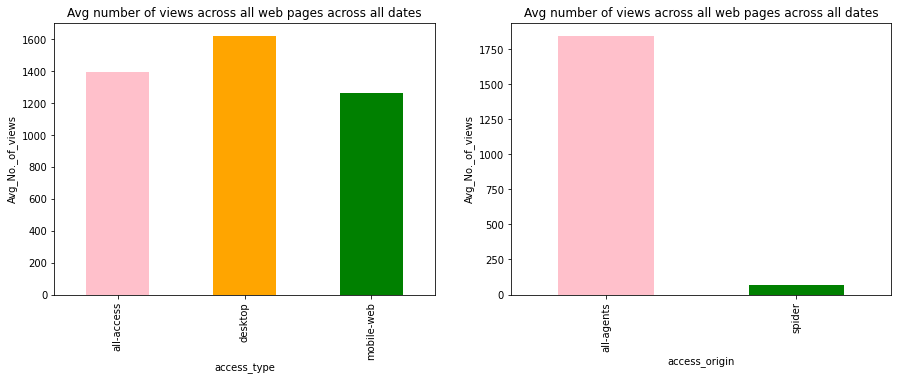

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Avg number of views across all web pages across all dates')
df.groupby('access_type').mean().mean(axis=1).plot(kind='bar', color=['pink', 'orange', 'green'])
plt.ylabel('Avg_No._of_views')
plt.subplot(1,2,2)
plt.title('Avg number of views across all web pages across all dates')
df.groupby('access_origin').mean().mean(axis=1).plot(kind='bar', color=['pink', 'green'])
plt.ylabel('Avg_No._of_views')
plt.show()

> Inference from the above plots
> - Webpages that can only be accessed from desktop has more number of views as compared to other access types on an average across all dates. 
> - Webpages that has access origin as spider has way less as compared to all-agents origin on an average across all dates.

In [13]:
# Getting seperate data frames for individual languages.
df_chinese = df[df.language == 'zh'].iloc[:,3:]
df_french = df[df.language == 'fr'].iloc[:,3:]
df_english = df[df.language == 'en'].iloc[:,3:]
df_german = df[df.language == 'de'].iloc[:,3:]
df_russian = df[df.language == 'ru'].iloc[:,3:]
df_japanese = df[df.language == 'ja'].iloc[:,3:]
df_spanish = df[df.language == 'es'].iloc[:,3:]
df_mixed = df[df.language == 'na'].iloc[:,3:]

### Chinese language time series

In [14]:
# We do not know if the columns are sorted left to right
df_chinese = df_chinese.reindex(sorted(df_chinese.columns), axis=1)
df_chinese.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
0         9.0        22.0        26.0        24.0  ...        32.0   
1        22.0        11.0        10.0         4.0  ...        17.0   
2         0.0         3.0         4.0         4.0  ...         3.0   
3        14.0         9.0        11.0        16.0  ...        32.0   
4         NaN         NaN         NaN         NaN  ...        48.0   

   2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
0        63.0        15.0        26.0        14.0        20.0        22.0   
1        42.0        28.0        15.0         9.0        30.0        52.0   
2         1.0         1.0         7.0         4.0         4.0         6.0   
3        10.0        26.0        27.0        16.0        11.0        17.0   
4         9.0        25.0        13.0         3.0        11.0        27.0   

   2016-12-29  2016-12-30  2016-12-31  
0        19.0        18.0        20.0  
1        45.0        26.0        20.0  
2         3.0         4.0        17.0  
3        19.0        10.0        11.0  
4        13.0        36.0        10.0  

[5 rows x 550 columns]

In [15]:
df_chinese.shape

(17229, 550)

In [16]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_chinese.columns[0], df_chinese.columns[-1]

('2015-07-01', '2016-12-31')

In [17]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_chinese.columns[-1]) - pd.to_datetime(df_chinese.columns[0])).split()[0])+1

550

In [18]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_chinese.isna().sum(axis=1)

0           0
1           0
2           0
3           0
4         291
         ... 
109445    550
109446    550
109447    550
109448    550
109449    550
Length: 17229, dtype: int64

In [19]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_chinese.isna().sum(axis=1)[df_chinese.isna().sum(axis=1)/550 >= 0.05].index
df_chinese.drop(nan_indices, inplace=True)
df_chinese.isna().sum(axis=1)[df_chinese.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [20]:
# Filling the missing values page wise using the bfill technique. 
df_chinese.fillna(method='bfill', axis=1, inplace=True)

In [21]:
# Getting the sum of views of all the pages combined for each date.
df_chinese = df_chinese.sum().to_frame(name='No_of_views').rename_axis('Date')
df_chinese = df_chinese.reset_index()
df_chinese['Date'] = pd.to_datetime(df_chinese.Date) # Converting Date column to date_time 

In [22]:
# We donot have any missing values
df_chinese.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [23]:
df_chinese.groupby([df_chinese.Date.dt.year, df_chinese.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [24]:
df_chinese.groupby([df_chinese.Date.dt.year, df_chinese.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [25]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_chinese = df_chinese.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_chinese = df_chinese.set_index('Date').loc['2016-10-01':,:].reset_index()

In [26]:
train_chinese.shape, test_chinese.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

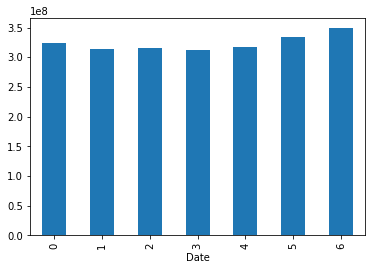

In [27]:
# Comparing total No of views on weekly basis.
# views on saturdays are higher compared to other days of the week. 
train_chinese.groupby(train_chinese.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [28]:
# Getting the first date of every month and also the saturdays of every week.
saturdays = train_chinese[(train_chinese.Date.dt.dayofweek == 6)].Date.values
month_1st_dates =  train_chinese[(train_chinese.Date.dt.day == 1)].Date.values

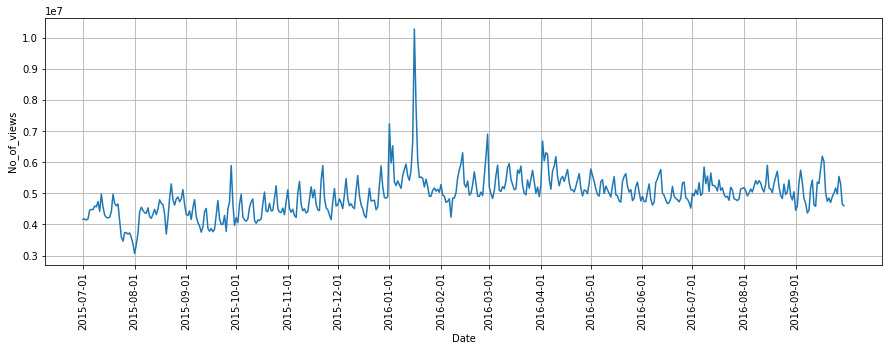

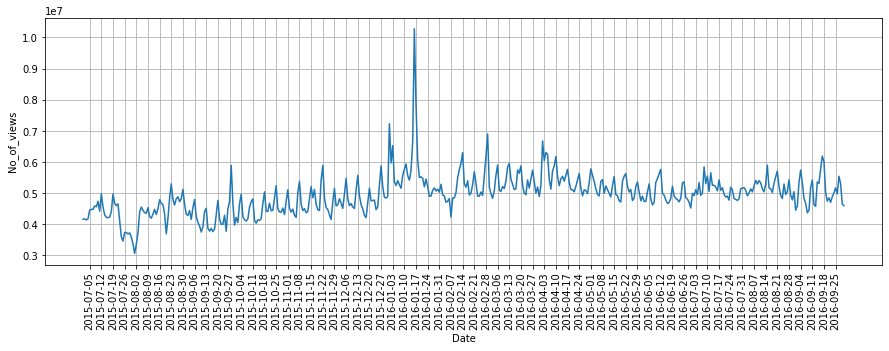

In [29]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_chinese.Date, train_chinese.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_chinese.Date, train_chinese.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on saturdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [229]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_chinese.No_of_views)
# P-val = 0.18 which is is greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.2738515889599022,
 0.1805400692217068,
 14,
 443,
 {'1%': -3.4451978474132234,
  '5%': -2.8680864144212057,
  '10%': -2.5702569996789792},
 12376.625648263469)

#### Time series decomposition

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

chinese_decomp = seasonal_decompose(train_chinese.set_index('Date'), two_sided=False)

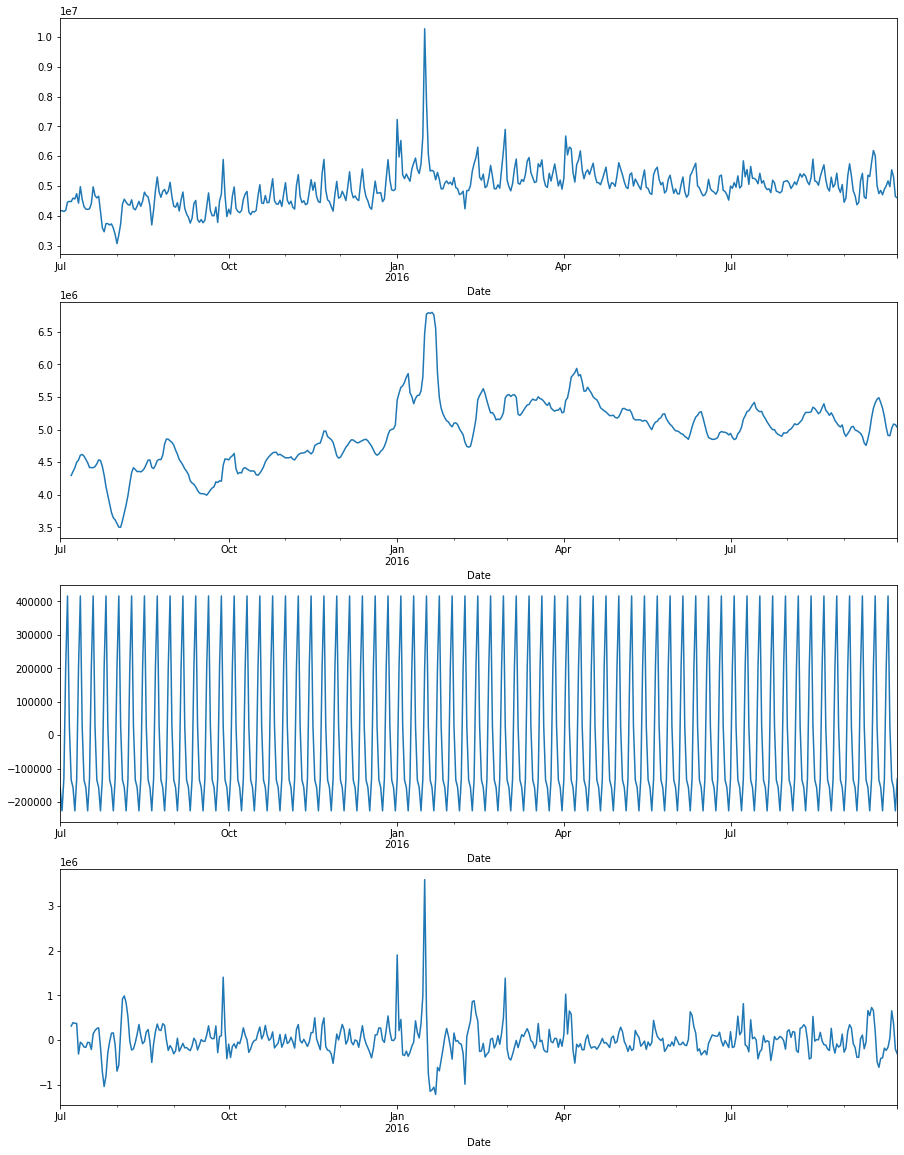

In [32]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
chinese_decomp.observed.plot()
plt.subplot(4,1,2)
chinese_decomp.trend.plot()
plt.subplot(4,1,3)
chinese_decomp.seasonal.plot()
plt.subplot(4,1,4)
chinese_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [33]:
chinese_decomp.resid

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
                  ...      
2016-09-26     45866.142612
2016-09-27    656115.218230
2016-09-28    375143.086362
2016-09-29   -203856.120232
2016-09-30   -305483.777374
Name: resid, Length: 458, dtype: float64

In [34]:
from statsmodels.tsa.stattools import adfuller

adfuller(chinese_decomp.resid[6:])
# P-val = 0.102*10^-17 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-9.709582964905996,
 1.0200416130476972e-16,
 7,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 12196.119750435253)

#### Stationary conversion - Detrending

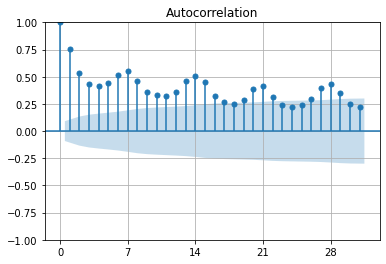

In [35]:
# At 1 and 2 lags, I can see medium to high correlation. 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_chinese.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [36]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_chinese.No_of_views.diff()
detrend

0           NaN
1        6541.0
2      -28343.0
3       39428.0
4      277508.0
         ...   
453   -191348.0
454    563418.0
455   -238429.0
456   -657067.0
457    -47717.0
Name: No_of_views, Length: 458, dtype: float64

In [37]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 0.14*10^-10 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-6.877877635959594,
 1.4587462134767394e-09,
 18,
 438,
 {'1%': -3.445368352170937,
  '5%': -2.8681614049724002,
  '10%': -2.570296970872167},
 12531.742884796158)

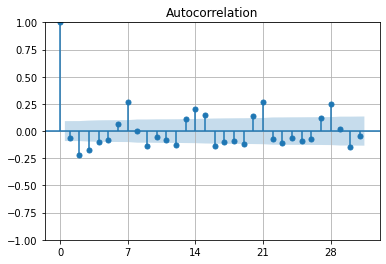

In [38]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

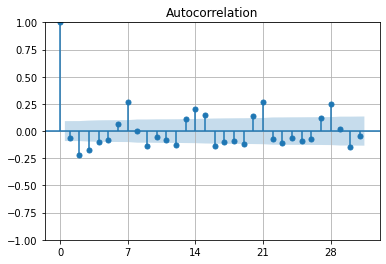

In [39]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

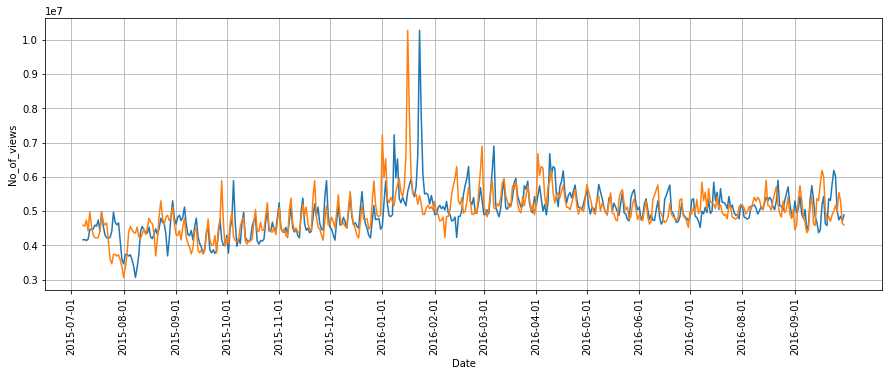

In [40]:
# We can see that almost all the seasonal peaks coincide.
plt.figure(figsize=(15,5))
sns.lineplot(train_chinese.Date, train_chinese.No_of_views.shift(7))
sns.lineplot(train_chinese.Date, train_chinese.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [41]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8     -34886.0
9     205492.0
10   -356886.0
Name: No_of_views, dtype: float64

In [42]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 0.23*10^-15 which is way less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-8.783570494737877,
 2.3411168559595462e-14,
 16,
 433,
 {'1%': -3.445542818501549,
  '5%': -2.868238133603207,
  '10%': -2.5703378690483176},
 12403.26320556905)

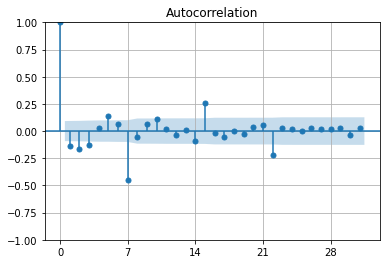

In [43]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

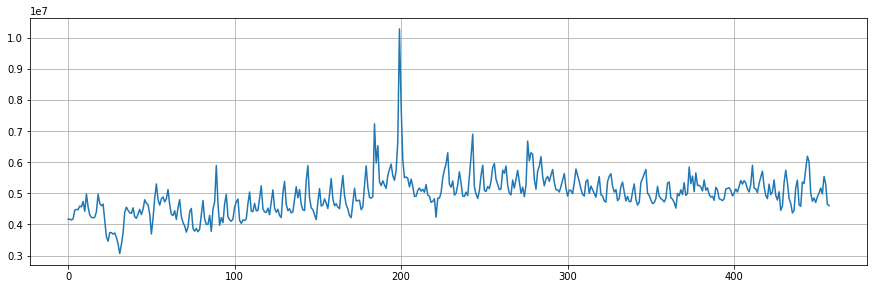

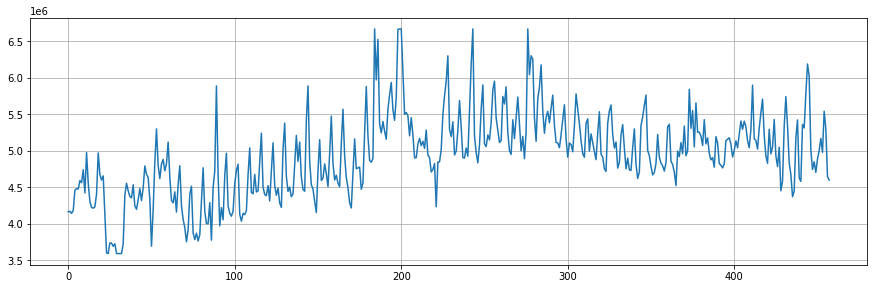

In [44]:
# Plots before and after clipping. 
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_chinese.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_chinese.No_of_views.clip(upper=train_chinese.No_of_views.quantile(0.99), 
                               lower=train_chinese.No_of_views.quantile(0.01)).plot(kind='line')
plt.grid()
plt.show()

In [45]:
# Clipping the anamolies or outliers. Anything below 1 percentine and anything above 99 percentile will be clipeed. 
train_chinese['No_of_views'] = train_chinese.No_of_views.clip(upper=train_chinese.No_of_views.quantile(0.99), 
                               lower=train_chinese.No_of_views.quantile(0.01))

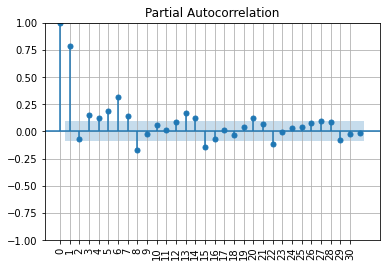

In [46]:
# I can see that some of the lines until 27 lags appear to be a bit significant as per the confidence intervals. 
# If we do not consider seasonality, only the first 7 or 8 lags appear to a bit significant.
plot_pacf(train_chinese.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [47]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
# Using only the first 7 and 8 lags as order for p and q
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,8), 'q':np.arange(1,8)}))

arima_mapes = []

for i in range(len(param_grid)):
    chinese_arima = SARIMAX(train_chinese.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_chinese.No_of_views, chinese_arima.forecast(len(test_chinese)))*100)

In [48]:
# For trend_order = (4,1,6), I could get the MAPE as 5.1%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 4, 'q': 6}, 5.118063012186638)

> -  Best MAPE with ARIMAX for test set is 5.1%

In [49]:
# Retraining the model with the best params for the entire train set.
chinese_arima = SARIMAX(train_chinese.No_of_views, order=(5,1,7)).fit(disp=False)

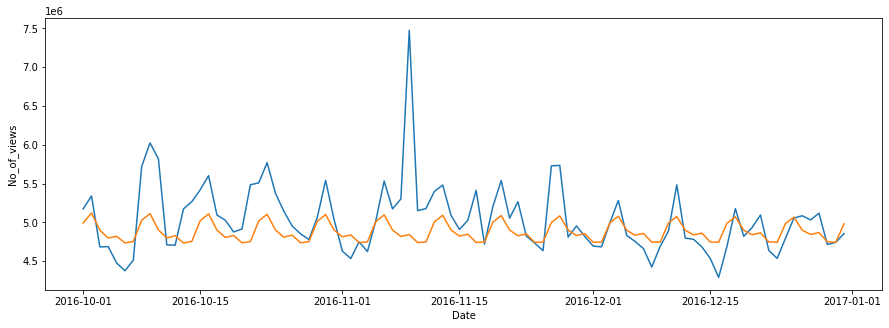

In [50]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_chinese.Date, y=test_chinese.No_of_views)
sns.lineplot(x=test_chinese.Date, y=chinese_arima.forecast(len(test_chinese)).values)
plt.show()

#### Modelling - SARIMAX

In [51]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

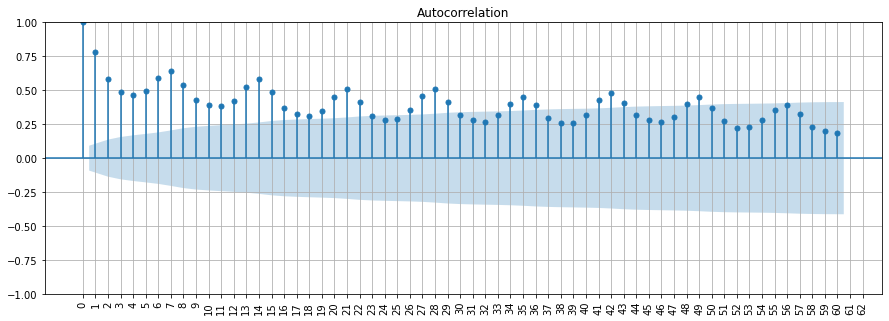

In [52]:
# Some of the seasonal lines (Multiples of 7) appear to be bit significant until 49 as per the confidence intervals. 
# From this plot, I will take the first 7 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_chinese.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

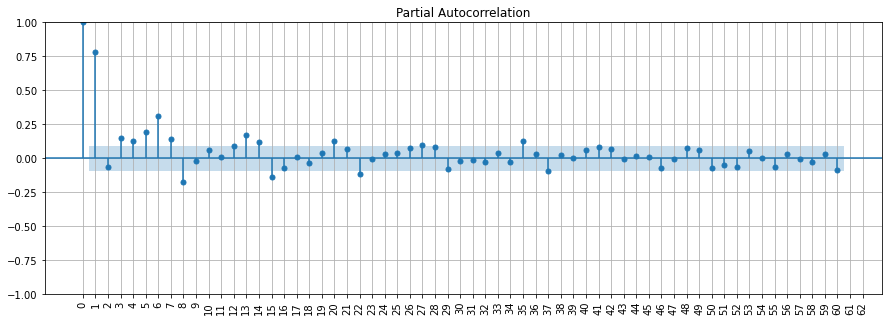

In [53]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_chinese.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [54]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, I will keep the values as 4 and 6(Best params obtained from ARIMA gridsearch)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1,2,3], 'Q':np.arange(1,8)}))

sarimax_mapes = []

for i in range(len(param_grid)):
    chinese_sarimax = SARIMAX(train_chinese.No_of_views,
                            exog = exog.Campaign[:len(train_chinese)], 
                            order=(4, 1, 6), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = chinese_sarimax.forecast(steps = len(test_chinese), 
                                             exog = exog.Campaign[len(train_chinese):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_chinese.No_of_views, test_forecast)*100)

In [55]:
# For params (4,1,6) and (1,1,7,7), I could get an MAPE as 4.99% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 1, 'Q': 7}, 4.994018352122931)

> -  Best MAPE with SARIMAX for test set is 4.99%

In [56]:
# Retraining the sarimax model with the best params
chinese_sarimax = SARIMAX(train_chinese.No_of_views, 
                          order=(4,1,6), 
                          seasonality_order=(1, 1, 7, 7), 
                          exog = exog.Campaign[:len(train_chinese)]).fit(disp=False)
test_forecast = chinese_sarimax.forecast(steps = len(test_chinese), 
                                             exog = exog.Campaign[len(train_chinese):].reset_index(drop=True))

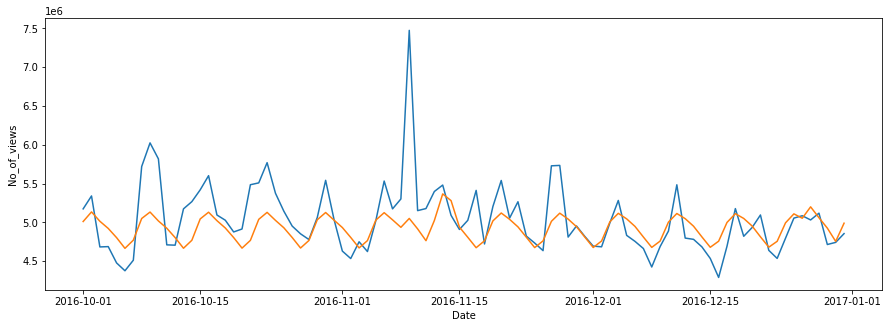

In [57]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_chinese.Date, y=test_chinese.No_of_views)
sns.lineplot(x=test_chinese.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [58]:
# Adding Exogenous variable campaign to train data frame
train_chinese['Campaign'] = exog['Campaign'][:train_chinese.shape[0]]
train_chinese.head()

Date  No_of_views  Campaign
0 2015-07-01    4165013.0         0
1 2015-07-02    4171554.0         0
2 2015-07-03    4143211.0         0
3 2015-07-04    4182639.0         0
4 2015-07-05    4460147.0         0

In [59]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

chinese_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(chinese_prophet, 'Campaign')
chinese_prophet.fit(train_chinese.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = chinese_prophet.make_future_dataframe(periods=len(test_chinese),freq="D")
future['Campaign'] = exog['Campaign']
forecast = chinese_prophet.predict(future)

13:01:19 - cmdstanpy - INFO - Chain [1] start processing
13:01:19 - cmdstanpy - INFO - Chain [1] done processing


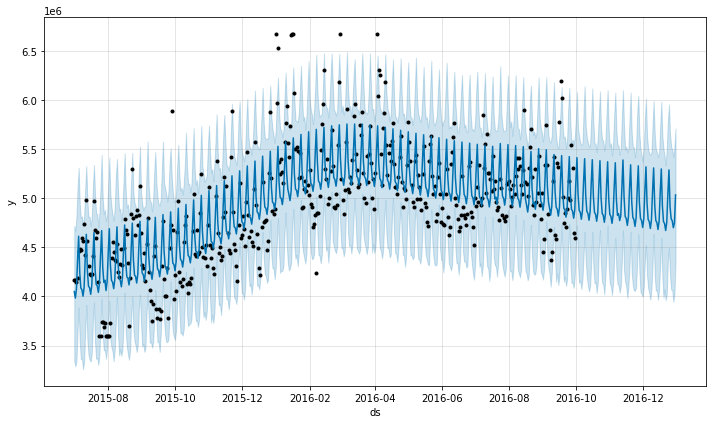

In [60]:
chinese_prophet.plot(forecast)
plt.show()

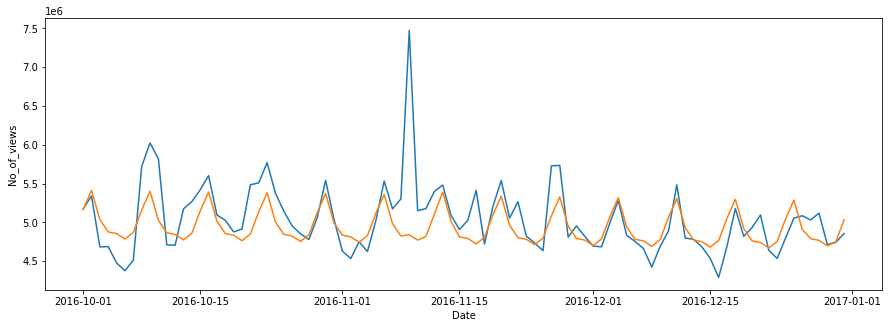

In [61]:
# The peaks fit and align better than SARIMAX model. No hyperparameter tuning was also required. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_chinese.Date, y=test_chinese.No_of_views)
sns.lineplot(x=test_chinese.Date, y=forecast.iloc[len(train_chinese):, :].yhat.values)
plt.show()

In [62]:
# We got 4.5% MAPE which is better than SARIMAX
mean_absolute_percentage_error(test_chinese.No_of_views, forecast.iloc[len(train_chinese):, :].yhat)*100

4.555223185644527

###  English language time series

In [63]:
# We do not know if the columns are sorted left to right
df_english = df_english.reindex(sorted(df_english.columns), axis=1)
df_english.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
8357         3.0         4.0         7.0         4.0         4.0         2.0   
8358         NaN         NaN         NaN         NaN         NaN         NaN   
8359         NaN         NaN         NaN         NaN         NaN         NaN   
8360      2403.0     20136.0      1850.0      1432.0      1351.0      1792.0   
8361       982.0       881.0       794.0       979.0      1191.0      1057.0   

      2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
8357         3.0         7.0         2.0         NaN  ...         3.0   
8358         NaN         NaN         NaN         NaN  ...      2898.0   
8359         NaN         NaN         1.0         0.0  ...         1.0   
8360      1710.0      2039.0      1957.0      1640.0  ...      1401.0   
8361      1184.0       860.0      1259.0      1257.0  ...       404.0   

      2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
8357         1.0         6.0         3.0         1.0         1.0         3.0   
8358      2676.0      2032.0      2294.0      2074.0      2175.0      2156.0   
8359         NaN         NaN         NaN         NaN         NaN         NaN   
8360      1238.0       976.0       810.0       989.0      1332.0      1243.0   
8361       344.0       225.0       229.0       335.0       313.0       379.0   

      2016-12-29  2016-12-30  2016-12-31  
8357         3.0         1.0         0.0  
8358      2302.0      2098.0      1770.0  
8359         NaN         1.0         2.0  
8360      1681.0      1303.0      1098.0  
8361       393.0       354.0       272.0  

[5 rows x 550 columns]

In [64]:
df_english.shape

(24111, 550)

In [65]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_english.columns[0], df_english.columns[-1]

('2015-07-01', '2016-12-31')

In [66]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_english.columns[-1]) - pd.to_datetime(df_english.columns[0])).split()[0])+1

550

In [67]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_english.isna().sum(axis=1)

8357       24
8358      502
8359      392
8360        0
8361        0
         ... 
113946    244
113947      5
113948      4
113949     77
113950      1
Length: 24111, dtype: int64

In [68]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_english.isna().sum(axis=1)[df_english.isna().sum(axis=1)/550 >= 0.05].index
df_english.drop(nan_indices, inplace=True)
df_english.isna().sum(axis=1)[df_english.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [69]:
# Filling the missing values page wise using the bfill technique. 
df_english.fillna(method='bfill', axis=1, inplace=True)

In [70]:
# Getting the sum of views of all the pages combined for each date.
df_english = df_english.sum().to_frame(name='No_of_views').rename_axis('Date')
df_english = df_english.reset_index()
df_english['Date'] = pd.to_datetime(df_english.Date) # Converting Date column to date_time 

In [71]:
# We donot have any missing values
df_english.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [72]:
df_english.groupby([df_english.Date.dt.year, df_english.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [73]:
df_english.groupby([df_english.Date.dt.year, df_english.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [74]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_english = df_english.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_english = df_english.set_index('Date').loc['2016-10-01':,:].reset_index()

In [75]:
train_english.shape, test_english.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

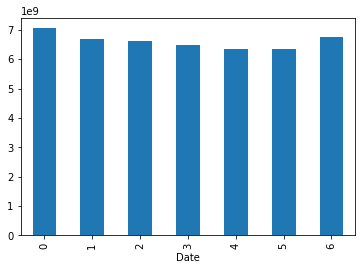

In [76]:
# Comparing total No of views on weekly basis.
# Views on sundays are higher compared to other days of the week. 
train_english.groupby(train_english.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [77]:
# Getting the first date of every month and also the saturdays of every week.
sundays = train_english[(train_english.Date.dt.dayofweek == 0)].Date.values
month_1st_dates =  train_english[(train_english.Date.dt.day == 1)].Date.values

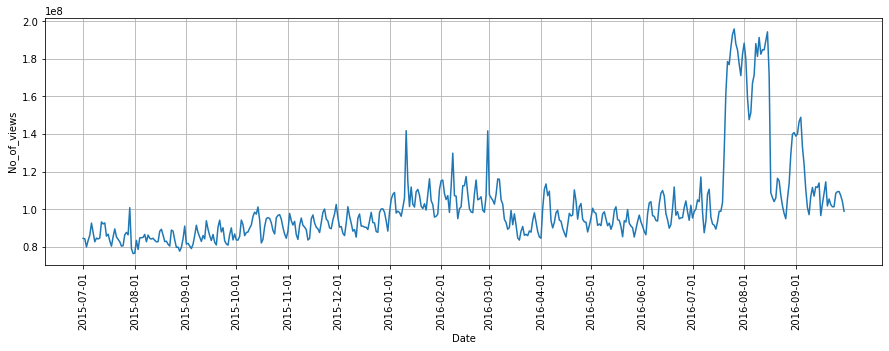

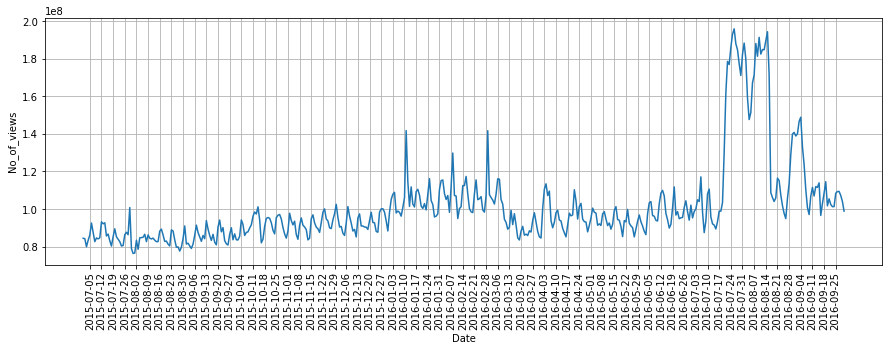

In [78]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_english.Date, train_english.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_english.Date, train_english.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on saturdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [79]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_english.No_of_views)
# P-val = 0.16 which is is greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.3338621551382595,
 0.161279166056078,
 14,
 443,
 {'1%': -3.4451978474132234,
  '5%': -2.8680864144212057,
  '10%': -2.5702569996789792},
 15128.87304598841)

#### Time series decomposition

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

english_decomp = seasonal_decompose(train_english.set_index('Date'), two_sided=False)

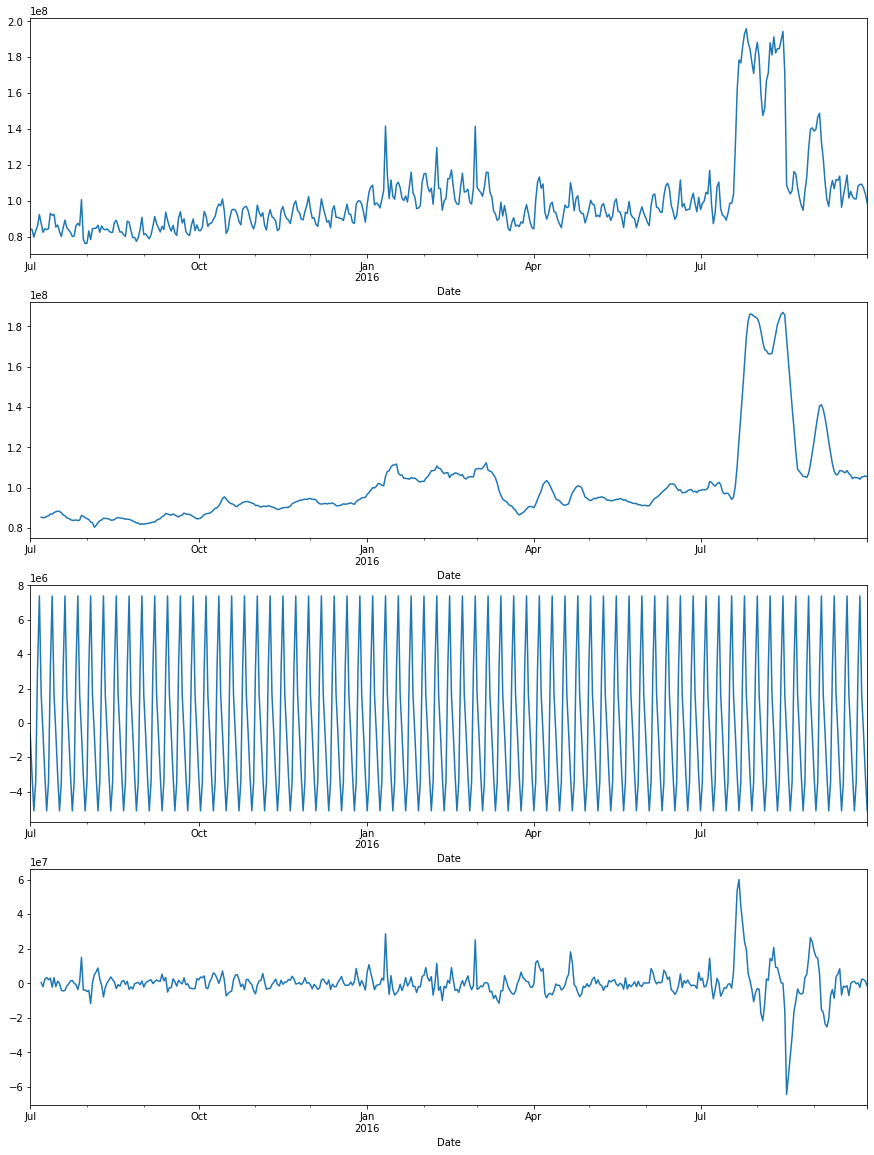

In [81]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
english_decomp.observed.plot()
plt.subplot(4,1,2)
english_decomp.trend.plot()
plt.subplot(4,1,3)
english_decomp.seasonal.plot()
plt.subplot(4,1,4)
english_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [82]:
english_decomp.resid

Date
2015-07-01             NaN
2015-07-02             NaN
2015-07-03             NaN
2015-07-04             NaN
2015-07-05             NaN
                  ...     
2016-09-26   -2.350785e+06
2016-09-27    2.381636e+06
2016-09-28    2.241181e+06
2016-09-29    1.271403e+06
2016-09-30   -1.515922e+06
Name: resid, Length: 458, dtype: float64

In [83]:
from statsmodels.tsa.stattools import adfuller

adfuller(english_decomp.resid[6:])
# P-val = 1.732363900273723e-14 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-8.83464155875308,
 1.732363900273723e-14,
 4,
 447,
 {'1%': -3.4450642060791097,
  '5%': -2.868027634065253,
  '10%': -2.5702256691640515},
 14723.507526381969)

#### Stationary conversion - Detrending

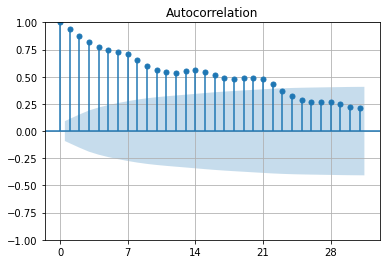

In [84]:
# I can see some good amount of correlation (Coeff > 0.5) until 15 lags.  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [85]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_english.No_of_views.diff()
detrend

0            NaN
1      -245041.0
2     -4284127.0
3      3443596.0
4      2770802.0
         ...    
453     910086.0
454      88102.0
455   -2130137.0
456   -3178160.0
457   -5199113.0
Name: No_of_views, Length: 458, dtype: float64

In [86]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 1.683144702071532e-10 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-7.260847403733651,
 1.683144702071532e-10,
 13,
 443,
 {'1%': -3.4451978474132234,
  '5%': -2.8680864144212057,
  '10%': -2.5702569996789792},
 15099.085077990228)

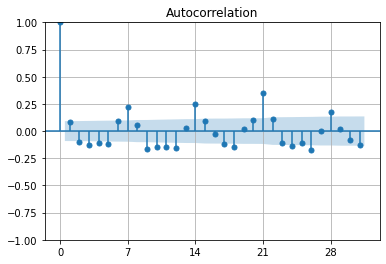

In [87]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

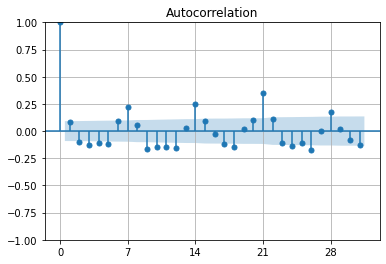

In [88]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

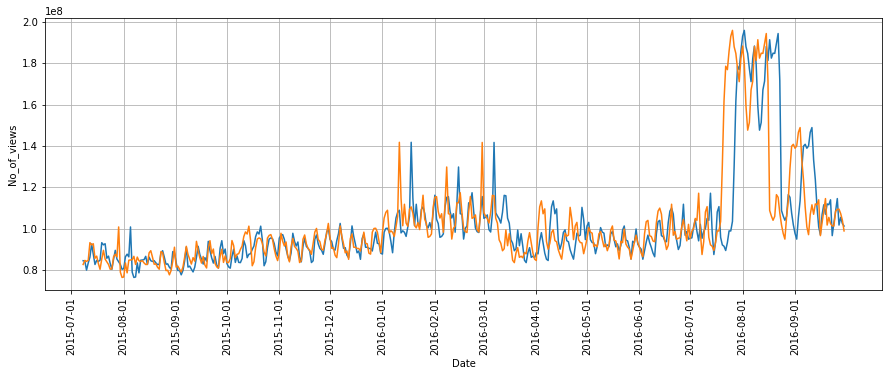

In [89]:
# We can see that almost all the seasonal peaks coincide except those insane outliers around 8th month in 2016.
plt.figure(figsize=(15,5))
sns.lineplot(train_english.Date, train_english.No_of_views.shift(7))
sns.lineplot(train_english.Date, train_english.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [90]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8     2203746.0
9     3807778.0
10   -2882387.0
Name: No_of_views, dtype: float64

In [91]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 2.2935576099018064e-24 which is way less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-13.035911394874491,
 2.2935576099018064e-24,
 13,
 436,
 {'1%': -3.445437655635993,
  '5%': -2.8681918844944785,
  '10%': -2.5703132171113543},
 14888.448585481958)

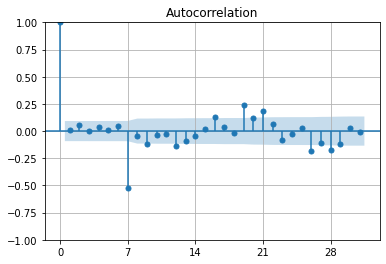

In [92]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

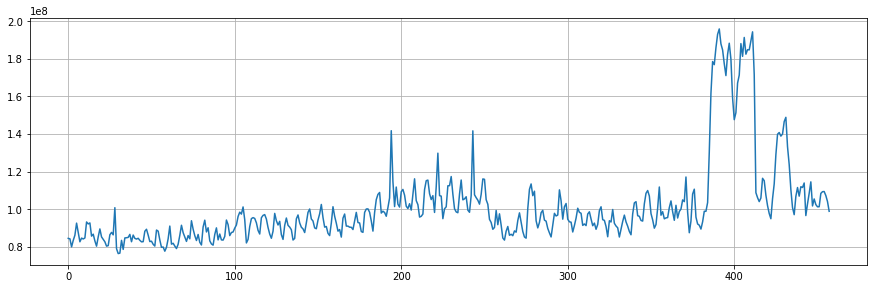

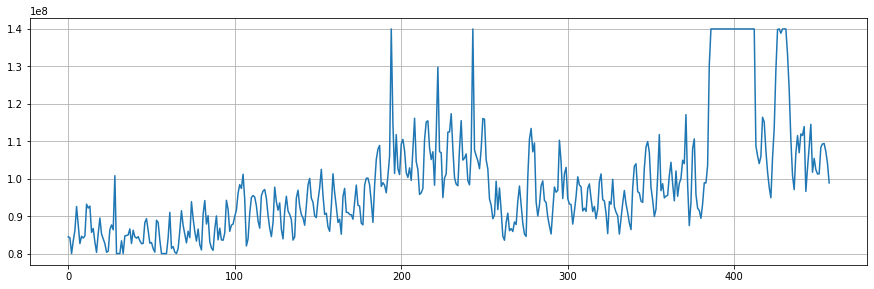

In [93]:
# Clipping the the top 7% and bottom 2% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_english.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_english.No_of_views.clip(upper=train_english.No_of_views.quantile(0.93), 
                               lower=train_english.No_of_views.quantile(0.02)).plot(kind='line')
plt.grid()
plt.show()

In [94]:
# Clipping the anamolies or outliers. Anything below 1 percentine and anything above 99 percentile will be clipeed. 
train_english['No_of_views'] = train_english.No_of_views.clip(upper=train_english.No_of_views.quantile(0.93), 
                               lower=train_english.No_of_views.quantile(0.02))

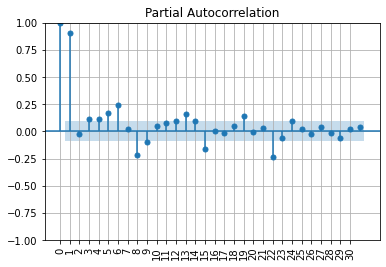

In [95]:
# I can see that some of the lines until 22 lags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 7 or 8 seasonality lags as hyperparameters p.
plot_pacf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

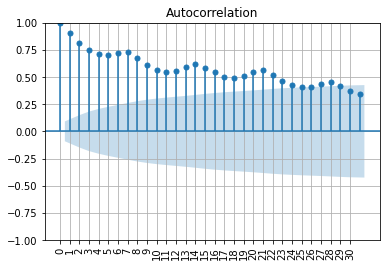

In [96]:
# I can see that some of the lines until 23 lags appear to be a bit significant as per the confidence intervals. 
#  I will take only the first 23 lags as hyperparameters q.
plot_acf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [97]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,8), 'q':np.arange(1,23)}))

arima_mapes = []

for i in range(len(param_grid)):
    english_arima = SARIMAX(train_english.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_english.No_of_views, english_arima.forecast(len(test_english)))*100)

In [98]:
# For order = (7,1,15), I could get the MAPE as 6.7%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 7, 'q': 15}, 6.716891421339188)

> -  Best MAPE with ARIMAX for test set is 6.7%

In [99]:
# Retraining the model with the best params for the entire train set.
english_arima = SARIMAX(train_english.No_of_views, order=(7,1,15)).fit(disp=False)

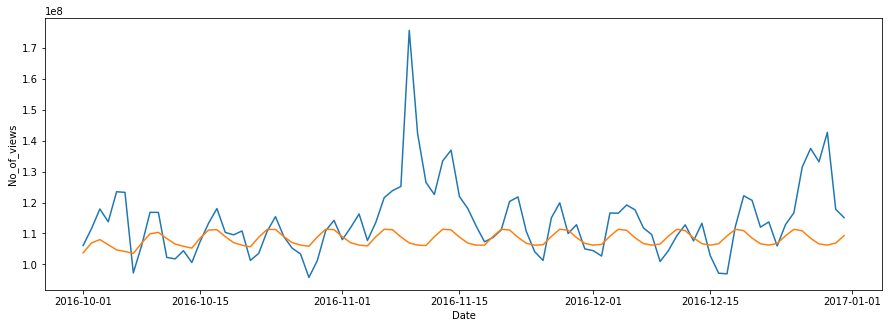

In [100]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=english_arima.forecast(len(test_english)).values)
plt.show()

#### Modelling - SARIMAX

In [101]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

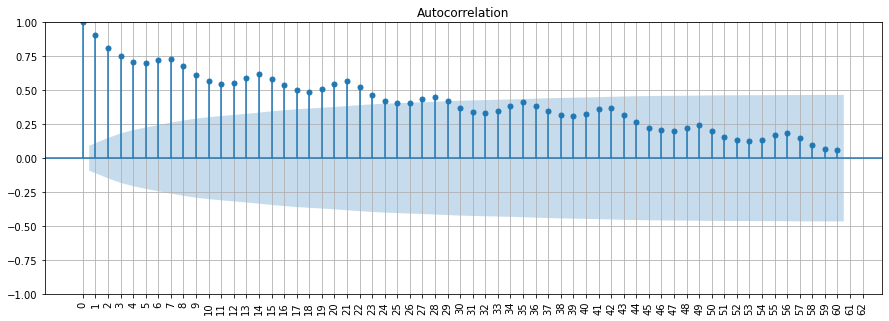

In [102]:
# Some of the seasonal lines (Multiples of 7) appear to be bit significant until 28 as per the confidence intervals. 
# From this plot, I will take the first 4 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_english.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

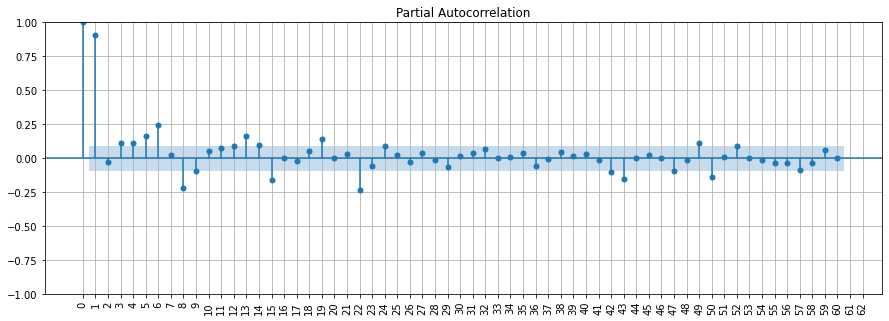

In [103]:
# From this plot, I will take only the first 2 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_english.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [104]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2], 'Q':[1,2,3,4]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    english_sarimax = SARIMAX(train_english.No_of_views,
                            exog = exog.Campaign[:len(train_english)], 
                            order=(6, 1, 6), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = english_sarimax.forecast(steps = len(test_english), 
                                             exog = exog.Campaign[len(train_english):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_english.No_of_views, test_forecast)*100)

In [105]:
# For params (6,1,6) and (2,1,1,7), I could get an MAPE as 4.91% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 2, 'Q': 1}, 4.919946453234682)

> -  Best MAPE with SARIMAX for test set is 4.91%

In [106]:
# Retraining the sarimax model with the best params
english_sarimax = SARIMAX(train_english.No_of_views, 
                          order=(6,1,6), 
                          seasonality_order=(2, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_english)]).fit(disp=False)
test_forecast = english_sarimax.forecast(steps = len(test_english), 
                                             exog = exog.Campaign[len(train_english):].reset_index(drop=True))

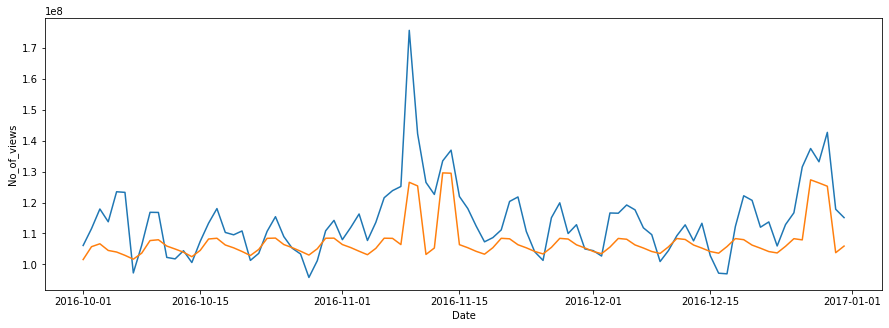

In [107]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [108]:
# Adding Exogenous variable campaign to train data frame
train_english['Campaign'] = exog['Campaign'][:train_english.shape[0]]
train_english.head()

Date  No_of_views  Campaign
0 2015-07-01  84482673.00         0
1 2015-07-02  84237632.00         0
2 2015-07-03  80006914.58         0
3 2015-07-04  83397101.00         0
4 2015-07-05  86167903.00         0

In [109]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

english_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(english_prophet, 'Campaign')
english_prophet.fit(train_english.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = english_prophet.make_future_dataframe(periods=len(test_english),freq="D")
future['Campaign'] = exog['Campaign']
forecast = english_prophet.predict(future)

13:06:35 - cmdstanpy - INFO - Chain [1] start processing
13:06:35 - cmdstanpy - INFO - Chain [1] done processing


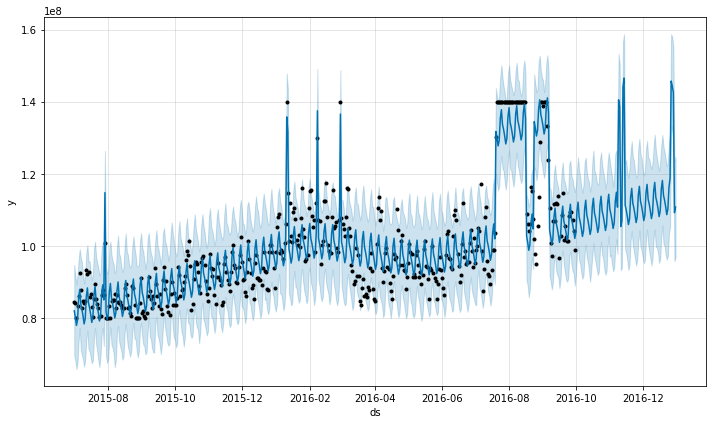

In [110]:
english_prophet.plot(forecast)
plt.show()

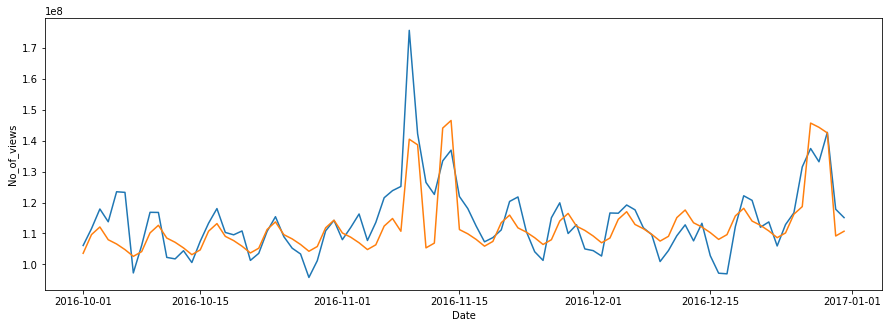

In [111]:
# The peaks fit and align better than SARIMAX model. No hyperparameter tuning was also required. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=forecast.iloc[len(train_english):, :].yhat.values)
plt.show()

In [112]:
# We got 4.77% MAPE which is better than SARIMAX
mean_absolute_percentage_error(test_english.No_of_views, forecast.iloc[len(train_english):, :].yhat)*100

4.777910904169349

###  French language time series

In [113]:
# We do not know if the columns are sorted left to right
df_french = df_french.reindex(sorted(df_french.columns), axis=1)
df_french.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
4310         NaN         NaN         NaN         NaN         NaN         NaN   
4311       421.0       438.0       351.0       259.0       329.0       383.0   
4312       203.0       188.0       208.0       169.0       170.0       172.0   
4313        19.0        14.0        20.0         8.0        10.0        26.0   
4314       250.0       200.0       179.0       183.0       204.0       204.0   

      2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
4310         NaN         NaN         NaN         NaN  ...       177.0   
4311       361.0       333.0       327.0       292.0  ...       535.0   
4312       147.0       194.0       143.0       196.0  ...       168.0   
4313        24.0        17.0         9.0        12.0  ...        45.0   
4314       212.0       212.0       185.0       197.0  ...       496.0   

      2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
4310       167.0       135.0       205.0       225.0       246.0       264.0   
4311       427.0       287.0       299.0       531.0       482.0       526.0   
4312       183.0       125.0       120.0       199.0       187.0       276.0   
4313        49.0        48.0        26.0        50.0        59.0        60.0   
4314       367.0       246.0      1039.0       499.0       445.0       413.0   

      2016-12-29  2016-12-30  2016-12-31  
4310       218.0       256.0       173.0  
4311       556.0       512.0       409.0  
4312       190.0       193.0       149.0  
4313        53.0        45.0        40.0  
4314       375.0       359.0       297.0  

[5 rows x 550 columns]

In [114]:
df_french.shape

(17802, 550)

In [115]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_french.columns[0], df_french.columns[-1]

('2015-07-01', '2016-12-31')

In [116]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_french.columns[-1]) - pd.to_datetime(df_french.columns[0])).split()[0])+1

550

In [117]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_french.isna().sum(axis=1)

4310      198
4311        0
4312        0
4313        0
4314        0
         ... 
131928    550
131929    550
131930    550
131931    550
131932    550
Length: 17802, dtype: int64

In [118]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_french.isna().sum(axis=1)[df_french.isna().sum(axis=1)/550 >= 0.05].index
df_french.drop(nan_indices, inplace=True)
df_french.isna().sum(axis=1)[df_french.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [119]:
# Filling the missing values page wise using the bfill technique. 
df_french.fillna(method='bfill', axis=1, inplace=True)

In [120]:
# Getting the sum of views of all the pages combined for each date.
df_french = df_french.sum().to_frame(name='No_of_views').rename_axis('Date')
df_french = df_french.reset_index()
df_french['Date'] = pd.to_datetime(df_french.Date) # Converting Date column to date_time 

In [121]:
# We donot have any missing values
df_french.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [122]:
df_french.groupby([df_french.Date.dt.year, df_french.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [123]:
df_french.groupby([df_french.Date.dt.year, df_french.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [124]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_french = df_french.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_french = df_french.set_index('Date').loc['2016-10-01':,:].reset_index()

In [125]:
train_french.shape, test_french.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

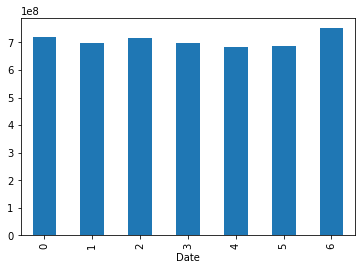

In [126]:
# Comparing total No of views on weekly basis.
# Views on saturdays are higher compared to other days of the week. 
train_french.groupby(train_french.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [127]:
# Getting the first date of every month and also the saturdays of every week.
saturdays = train_french[(train_french.Date.dt.dayofweek == 6)].Date.values
month_1st_dates =  train_french[(train_french.Date.dt.day == 1)].Date.values

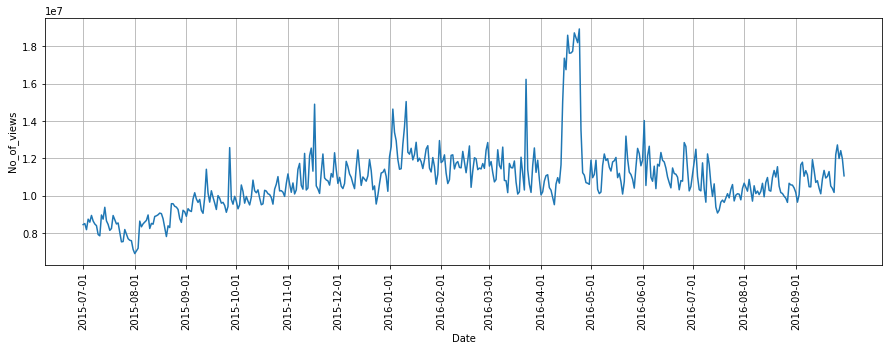

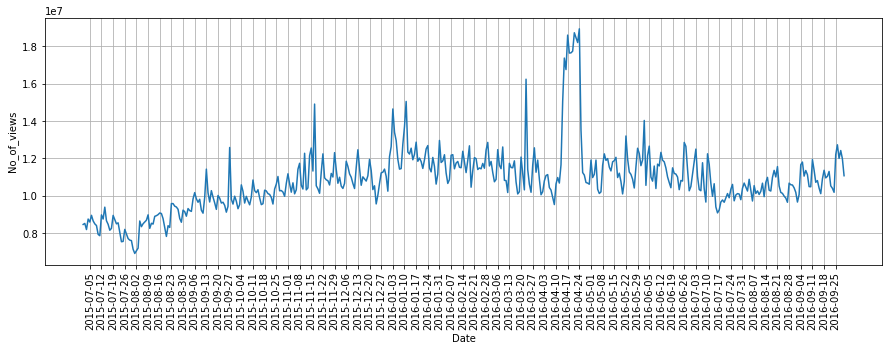

In [128]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_french.Date, train_french.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_french.Date, train_french.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on saturdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [129]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_french.No_of_views)
# P-val = 0.06 which is very close but greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.7604117545524174,
 0.06415495462199539,
 13,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 13235.210583896307)

#### Time series decomposition

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose

french_decomp = seasonal_decompose(train_french.set_index('Date'), two_sided=False)

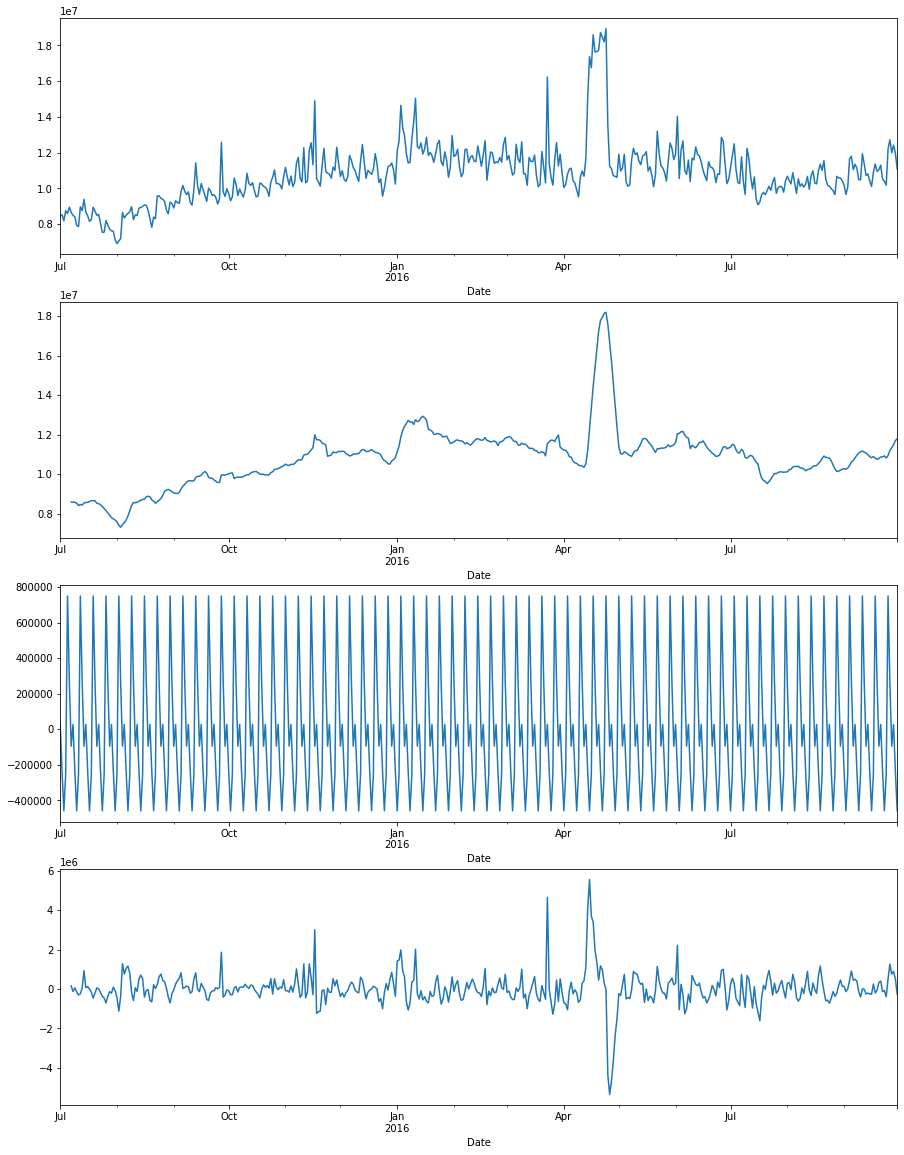

In [131]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
french_decomp.observed.plot()
plt.subplot(4,1,2)
french_decomp.trend.plot()
plt.subplot(4,1,3)
french_decomp.seasonal.plot()
plt.subplot(4,1,4)
french_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [132]:
french_decomp.resid

Date
2015-07-01             NaN
2015-07-02             NaN
2015-07-03             NaN
2015-07-04             NaN
2015-07-05             NaN
                  ...     
2016-09-26    1.263996e+06
2016-09-27    7.585490e+05
2016-09-28    8.985880e+05
2016-09-29    5.119943e+05
2016-09-30   -2.656511e+05
Name: resid, Length: 458, dtype: float64

In [133]:
from statsmodels.tsa.stattools import adfuller

adfuller(french_decomp.resid[6:])
# P-val = 1.5228933177865287e-14 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-8.856499327585016,
 1.5228933177865287e-14,
 10,
 441,
 {'1%': -3.4452655826028318,
  '5%': -2.868116205869215,
  '10%': -2.570272878944473},
 12869.408689323314)

#### Stationary conversion - Detrending

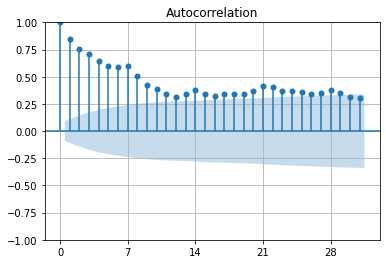

In [134]:
# I can see some good amount of correlation (Coeff > 0.5) until 8 lags.  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_french.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [135]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_french.No_of_views.diff()
detrend

0           NaN
1       54314.0
2     -327330.0
3      561987.0
4     -159286.0
         ...   
453    526444.0
454   -729204.0
455    422148.0
456   -442333.0
457   -905225.0
Name: No_of_views, Length: 458, dtype: float64

In [136]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 9.329042464131985e-13 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-8.157593384044182,
 9.329042464131985e-13,
 16,
 440,
 {'1%': -3.445299682487321,
  '5%': -2.8681312035123967,
  '10%': -2.570280872933884},
 13210.852129357496)

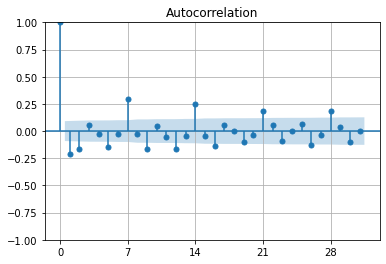

In [137]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

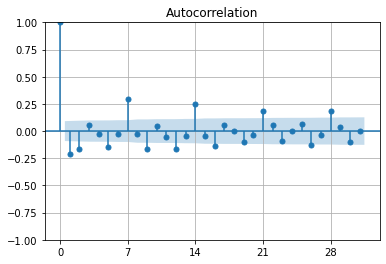

In [138]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

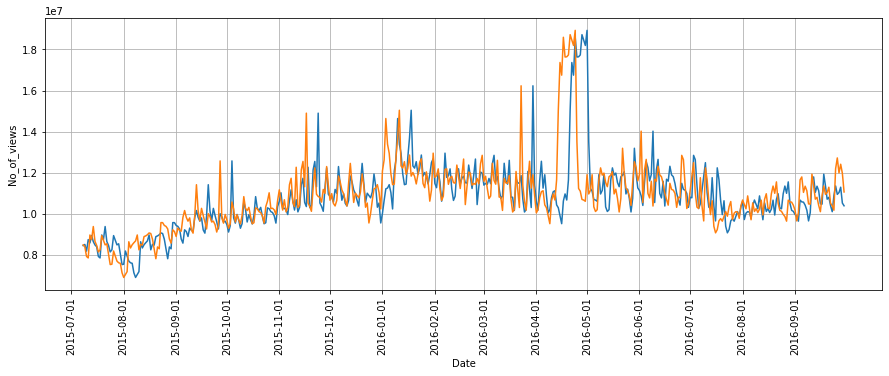

In [139]:
# We can see that almost all the seasonal peaks coincide except those insane outliers in 5th month of 2016.
plt.figure(figsize=(15,5))
sns.lineplot(train_french.Date, train_french.No_of_views.shift(7))
sns.lineplot(train_french.Date, train_french.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [140]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8    -143278.0
9    -145606.0
10   -632957.0
Name: No_of_views, dtype: float64

In [141]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 6.094860466722291e-14 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-8.62129842327897,
 6.094860466722291e-14,
 17,
 432,
 {'1%': -3.445578199334947,
  '5%': -2.8682536932290876,
  '10%': -2.570346162765775},
 13091.418611223005)

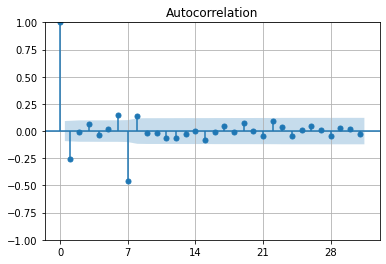

In [142]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

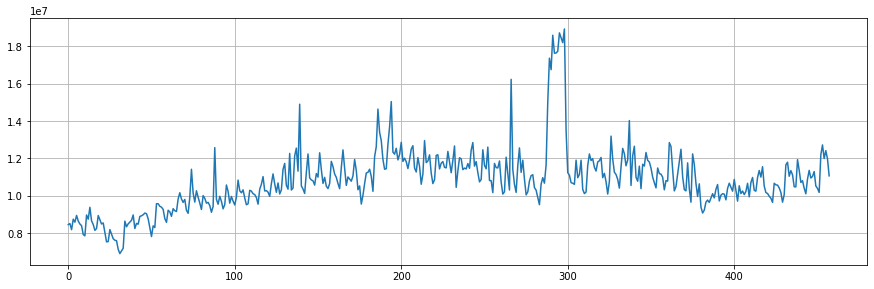

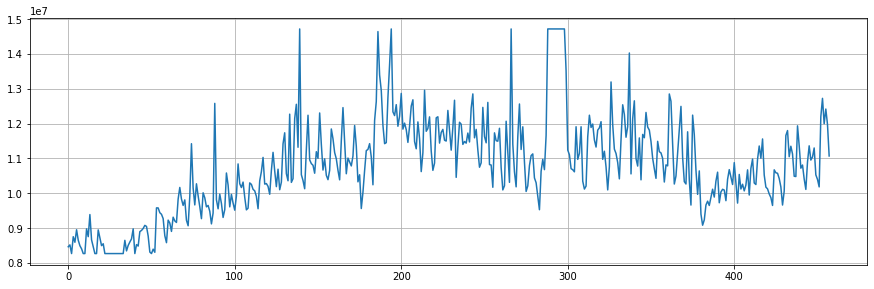

In [143]:
# Clipping the the top 3% and bottom 4% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_french.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_french.No_of_views.clip(upper=train_french.No_of_views.quantile(0.97), 
                               lower=train_french.No_of_views.quantile(0.04)).plot(kind='line')
plt.grid()
plt.show()

In [144]:
# Clipping the anamolies or outliers. Anything below 1 percentine and anything above 99 percentile will be clipeed. 
train_french['No_of_views'] = train_french.No_of_views.clip(upper=train_french.No_of_views.quantile(0.97), 
                               lower=train_french.No_of_views.quantile(0.04))

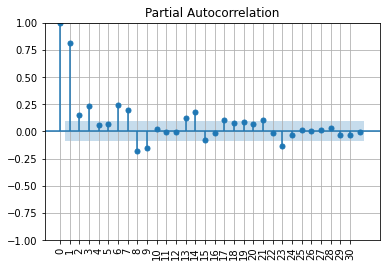

In [145]:
# I can see that some of the lines until 22 lags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 7 or 8 seasonality lags as hyperparameters p.
plot_pacf(train_french.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

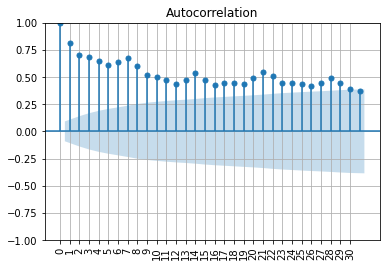

In [146]:
# I can see that some of the lines until 9 lags appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 9 lags as hyperparameters q.
plot_acf(train_french.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [147]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,9), 'q':np.arange(1,10)}))

arima_mapes = []

for i in range(len(param_grid)):
    french_arima = SARIMAX(train_french.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_french.No_of_views, french_arima.forecast(len(test_french)))*100)

In [148]:
# For order = (8,1,9), I could get the MAPE as 6.9%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 8, 'q': 9}, 6.932226993956236)

> -  Best MAPE with ARIMAX for test set is 6.9%

In [149]:
# Retraining the model with the best params for the entire train set.
french_arima = SARIMAX(train_french.No_of_views, order=(8,1,9)).fit(disp=False)

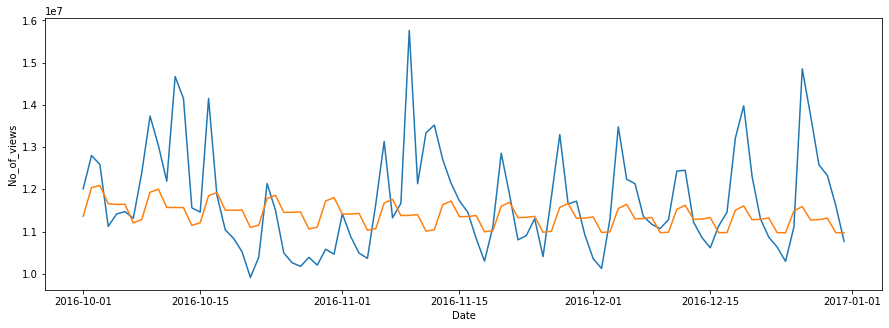

In [150]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_french.Date, y=test_french.No_of_views)
sns.lineplot(x=test_french.Date, y=french_arima.forecast(len(test_french)).values)
plt.show()

#### Modelling - SARIMAX

In [151]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

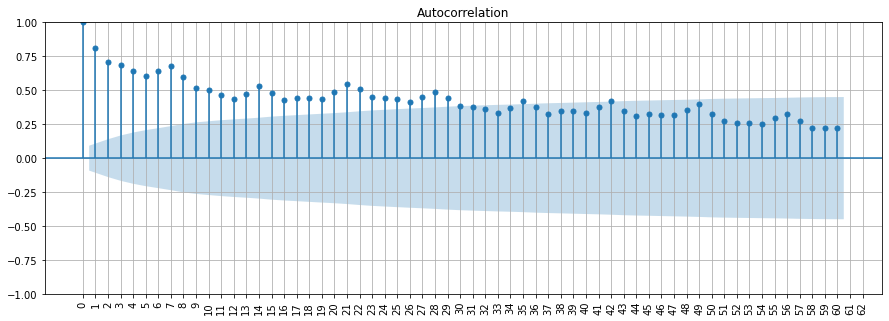

In [152]:
# Some of the seasonal lines (Multiples of 7) appear to be bit significant until 21 as per the confidence intervals. 
# From this plot, I will take the first 3 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_french.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

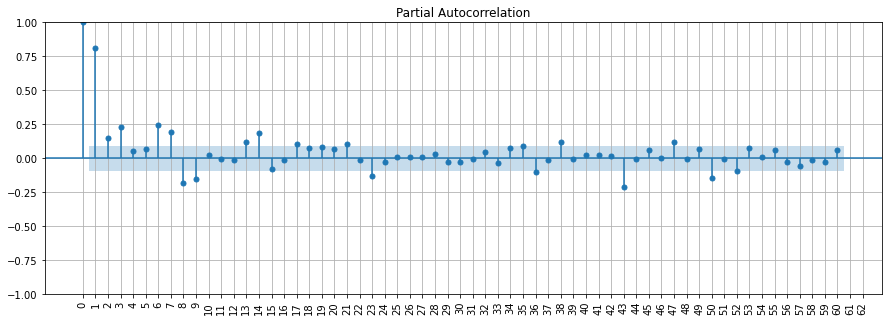

In [153]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_french.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [154]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2, 3], 'Q':[1,2,3]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    french_sarimax = SARIMAX(train_french.No_of_views,
                            exog = exog.Campaign[:len(train_french)], 
                            order=(6, 1, 5), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = french_sarimax.forecast(steps = len(test_french), 
                                             exog = exog.Campaign[len(train_french):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_french.No_of_views, test_forecast)*100)

In [155]:
# For params (6,1,5) and (1,1,1,7), I could get an MAPE as 6.39% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 1, 'Q': 1}, 6.397538672768512)

> -  Best MAPE with SARIMAX for test set is 6.39%

In [156]:
# Retraining the sarimax model with the best params
french_sarimax = SARIMAX(train_french.No_of_views, 
                          order=(6,1,5), 
                          seasonality_order=(1, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_french)]).fit(disp=False)
test_forecast = french_sarimax.forecast(steps = len(test_french), 
                                             exog = exog.Campaign[len(train_french):].reset_index(drop=True))

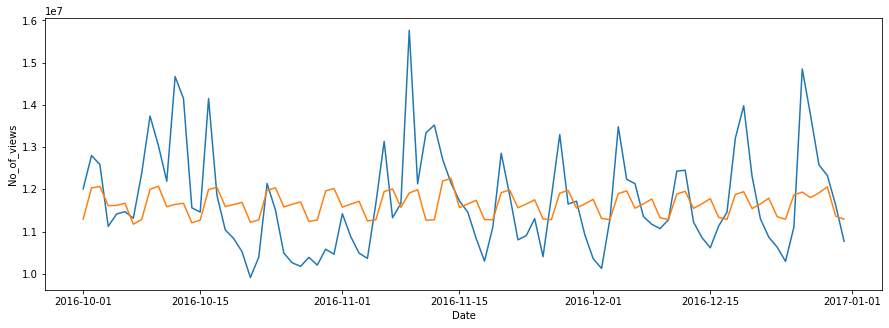

In [157]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_french.Date, y=test_french.No_of_views)
sns.lineplot(x=test_french.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [158]:
# Adding Exogenous variable campaign to train data frame
train_french['Campaign'] = exog['Campaign'][:train_french.shape[0]]
train_french.head()

Date  No_of_views  Campaign
0 2015-07-01   8464411.00         0
1 2015-07-02   8518725.00         0
2 2015-07-03   8269615.52         0
3 2015-07-04   8753382.00         0
4 2015-07-05   8594096.00         0

In [159]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

french_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(french_prophet, 'Campaign')
french_prophet.fit(train_french.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = french_prophet.make_future_dataframe(periods=len(test_french),freq="D")
future['Campaign'] = exog['Campaign']
forecast = french_prophet.predict(future)

13:08:09 - cmdstanpy - INFO - Chain [1] start processing
13:08:09 - cmdstanpy - INFO - Chain [1] done processing


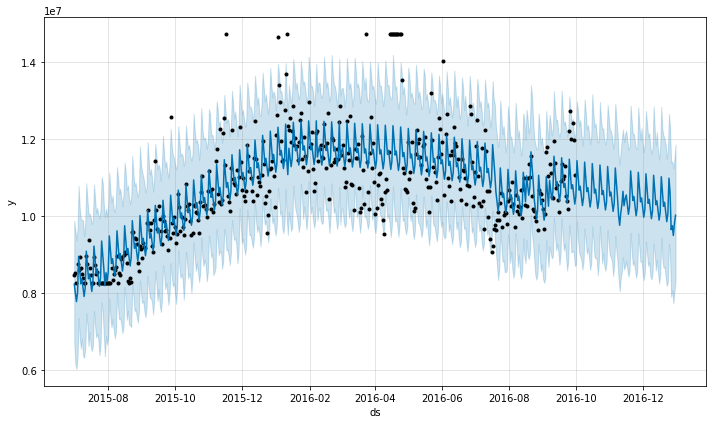

In [160]:
french_prophet.plot(forecast)
plt.show()

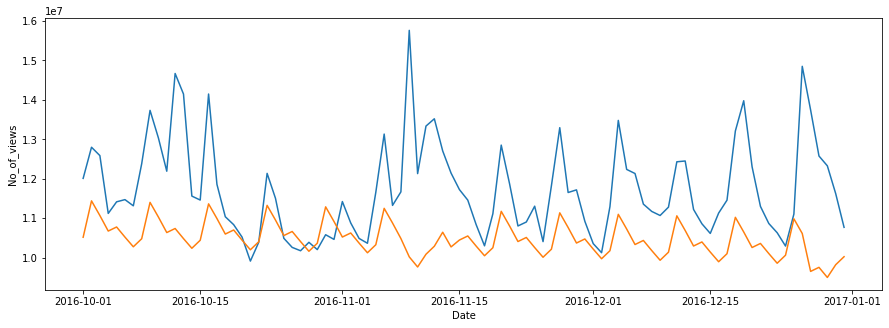

In [161]:
# I dont find any improvement here. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_french.Date, y=test_french.No_of_views)
sns.lineplot(x=test_french.Date, y=forecast.iloc[len(train_french):, :].yhat.values)
plt.show()

In [162]:
# We got 10.35% MAPE which is actually very bad as compared to SARIMAX.
mean_absolute_percentage_error(test_french.No_of_views, forecast.iloc[len(train_french):, :].yhat)*100

10.356235854821696

###  Russian language time series

In [163]:
# We do not know if the columns are sorted left to right
df_russian = df_russian.reindex(sorted(df_russian.columns), axis=1)
df_russian.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
15882       870.0       901.0      1034.0       773.0       759.0       776.0   
15883       982.0       897.0      1046.0      1159.0      1150.0      1139.0   
15884       253.0       266.0      5710.0      1625.0       567.0       277.0   
15885       285.0       284.0       351.0       349.0       343.0       359.0   
15886         NaN         NaN         0.0         NaN         0.0         NaN   

       2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
15882       827.0       925.0       910.0       961.0  ...       942.0   
15883      1219.0      1101.0      1181.0      1413.0  ...       229.0   
15884       223.0       223.0       459.0       225.0  ...       322.0   
15885       312.0       355.0       337.0       300.0  ...       515.0   
15886         0.0         0.0         NaN         NaN  ...       721.0   

       2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
15882       943.0       952.0       867.0       957.0       873.0       847.0   
15883       272.0       468.0       276.0       239.0       246.0       394.0   
15884       362.0       517.0       537.0       350.0       423.0       558.0   
15885       670.0       521.0       547.0       448.0       421.0       433.0   
15886       664.0      1092.0       744.0       608.0       586.0       611.0   

       2016-12-29  2016-12-30  2016-12-31  
15882       804.0       801.0       650.0  
15883       263.0       235.0       898.0  
15884       638.0       846.0      3019.0  
15885       412.0       444.0       372.0  
15886       639.0       786.0      1920.0  

[5 rows x 550 columns]

In [164]:
df_russian.shape

(15022, 550)

In [165]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_russian.columns[0], df_russian.columns[-1]

('2015-07-01', '2016-12-31')

In [166]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_russian.columns[-1]) - pd.to_datetime(df_russian.columns[0])).split()[0])+1

550

In [167]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_russian.isna().sum(axis=1)

15882       0
15883       0
15884       0
15885       0
15886      71
         ... 
127428    550
127429    550
127430    550
127431    550
127432    550
Length: 15022, dtype: int64

In [168]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_russian.isna().sum(axis=1)[df_russian.isna().sum(axis=1)/550 >= 0.05].index
df_russian.drop(nan_indices, inplace=True)
df_russian.isna().sum(axis=1)[df_russian.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [169]:
# Filling the missing values page wise using the bfill technique. 
df_russian.fillna(method='bfill', axis=1, inplace=True)

In [170]:
# Getting the sum of views of all the pages combined for each date.
df_russian = df_russian.sum().to_frame(name='No_of_views').rename_axis('Date')
df_russian = df_russian.reset_index()
df_russian['Date'] = pd.to_datetime(df_russian.Date) # Converting Date column to date_time 

In [171]:
# We donot have any missing values
df_russian.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [172]:
df_russian.groupby([df_russian.Date.dt.year, df_russian.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [173]:
df_russian.groupby([df_russian.Date.dt.year, df_russian.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [174]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_russian = df_russian.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_russian = df_russian.set_index('Date').loc['2016-10-01':,:].reset_index()

In [175]:
train_russian.shape, test_russian.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

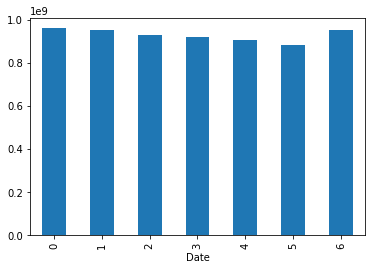

In [176]:
# Comparing total No of views on weekly basis.
# Views on saturdays are higher compared to other days of the week. 
# Even though the saturdays dominate, views on other days are also very close. 
train_russian.groupby(train_russian.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [177]:
# Getting the first date of every month and also the saturdays of every week.
saturdays = train_russian[(train_russian.Date.dt.dayofweek == 6)].Date.values
month_1st_dates =  train_russian[(train_russian.Date.dt.day == 1)].Date.values

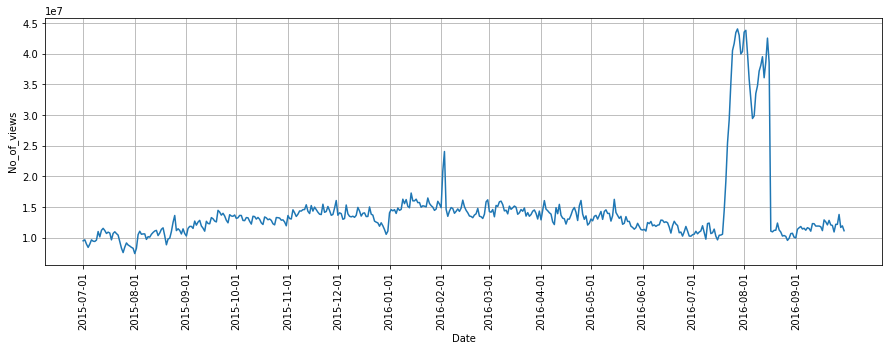

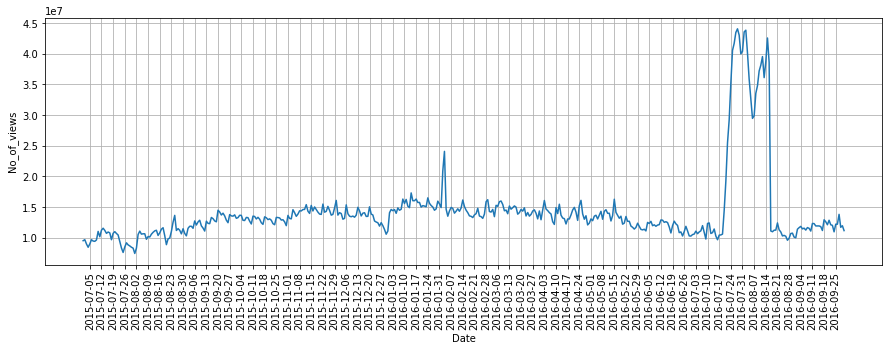

In [178]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_russian.Date, train_russian.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_russian.Date, train_russian.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - From the second plot, we can see that almost all the peaks are on saturdays of every week but still cannot confirm any seasonality as views are almost same on all days .Plot almost seems stationary. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [179]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_russian.No_of_views)
# P-val = 0.003 which is less than 0.05.
# We reject null hypothesis. Hence, time series is stationary.

(-3.764612389996976,
 0.003290852159964297,
 4,
 453,
 {'1%': -3.444868194858831,
  '5%': -2.867941416548597,
  '10%': -2.5701797149735146},
 13890.04908473)

#### Time series decomposition

In [180]:
from statsmodels.tsa.seasonal import seasonal_decompose

russian_decomp = seasonal_decompose(train_russian.set_index('Date'), two_sided=False)

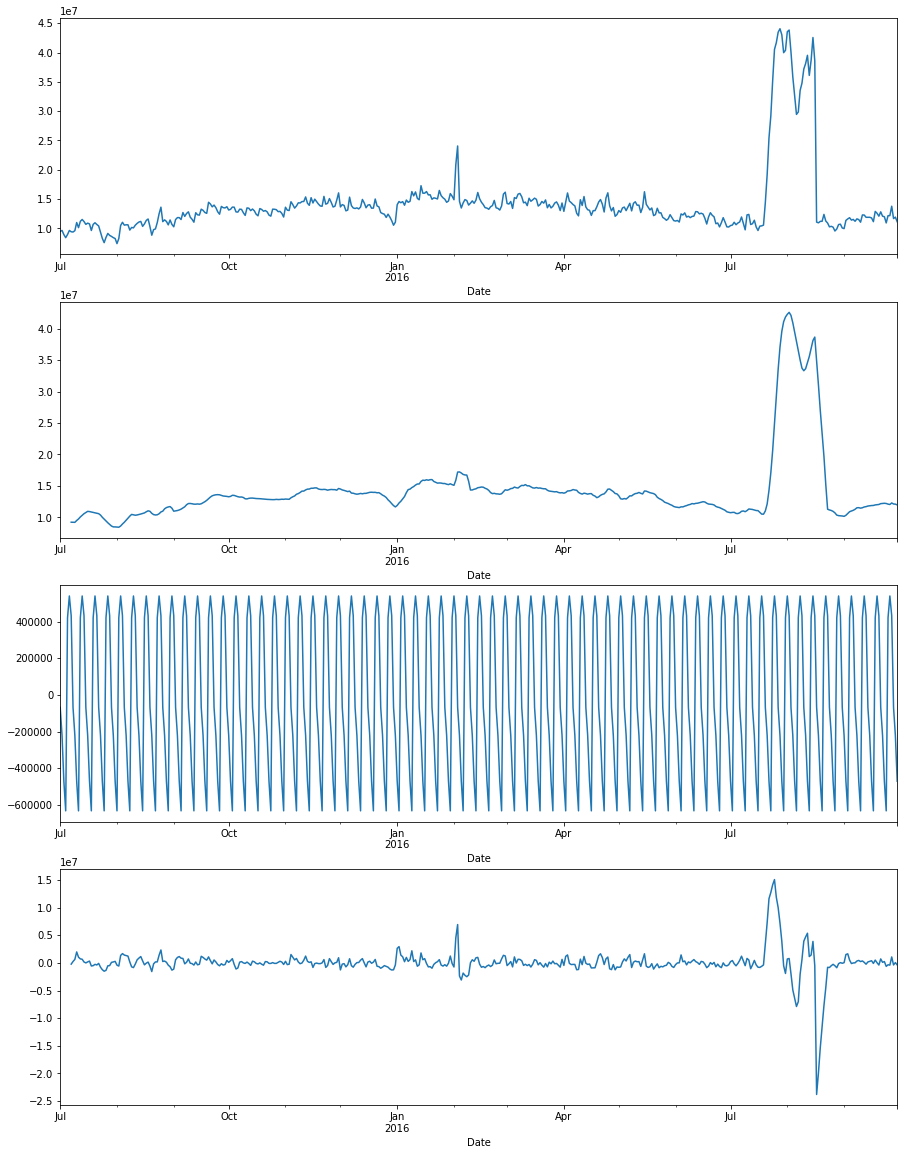

In [181]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
russian_decomp.observed.plot()
plt.subplot(4,1,2)
russian_decomp.trend.plot()
plt.subplot(4,1,3)
russian_decomp.seasonal.plot()
plt.subplot(4,1,4)
russian_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I see almost no trend or sideways trend in the plot. 

#### Stationary conversion - Detrending and Deseasonalising

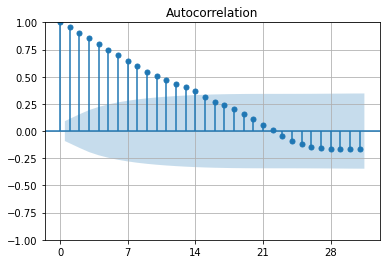

In [182]:
# As per AD-fuller test as the time series is stationary, there is no detrending or deseasonalising required. 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_russian.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

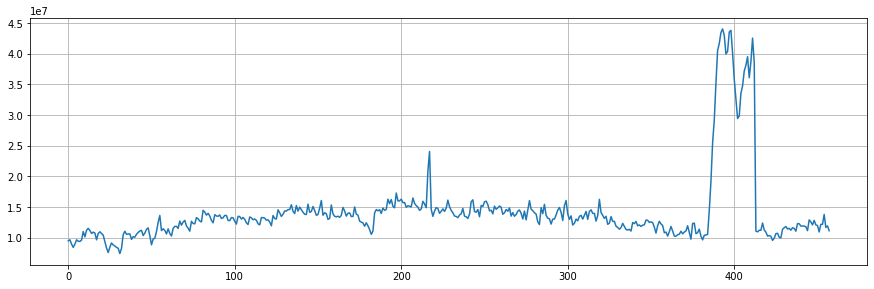

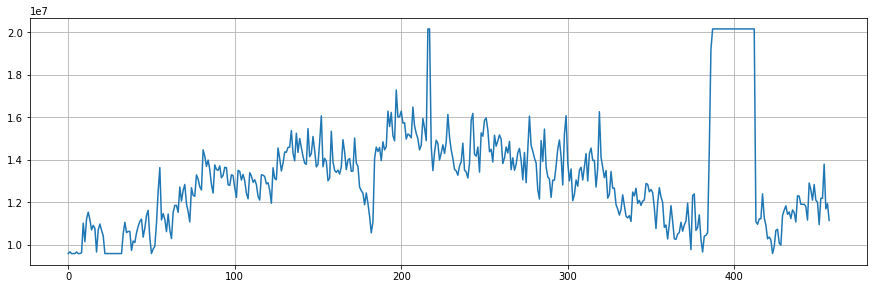

In [183]:
# Clipping the the top 6% and bottom 4% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_russian.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_russian.No_of_views.clip(upper=train_russian.No_of_views.quantile(0.94), 
                               lower=train_russian.No_of_views.quantile(0.04)).plot(kind='line')
plt.grid()
plt.show()

In [184]:
# Clipping the anamolies or outliers. Anything below 1 percentine and anything above 99 percentile will be clipeed. 
train_russian['No_of_views'] = train_russian.No_of_views.clip(upper=train_russian.No_of_views.quantile(0.94), 
                               lower=train_russian.No_of_views.quantile(0.04))

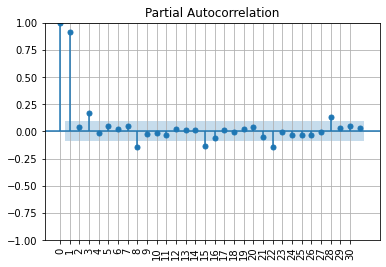

In [185]:
# I can see that some of the lines until 8 lags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 8 seasonality lags as hyperparameters p.
plot_pacf(train_russian.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

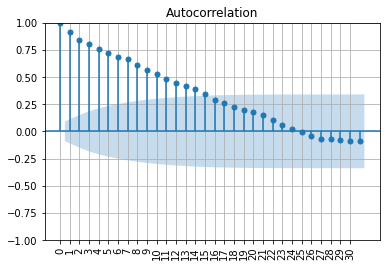

In [186]:
# I can see that some of the lines until 9 lags appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 9 lags as hyperparameters q.
plot_acf(train_russian.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [187]:
# Training the ARIMA model by keeping detrending or trend diff value as 1. 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,8), 'q':np.arange(1,10)}))

arima_mapes = []

for i in range(len(param_grid)):
    russian_arima = SARIMAX(train_russian.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_russian.No_of_views, russian_arima.forecast(len(test_russian)))*100)

In [188]:
# For order = (7,1,7), I could get the MAPE as 9.48%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 7, 'q': 7}, 9.481998227757906)

> -  Best MAPE with ARIMAX for test set is 9.48%

In [189]:
# Retraining the model with the best params for the entire train set.
russian_arima = SARIMAX(train_russian.No_of_views, order=(7,1,7)).fit(disp=False)

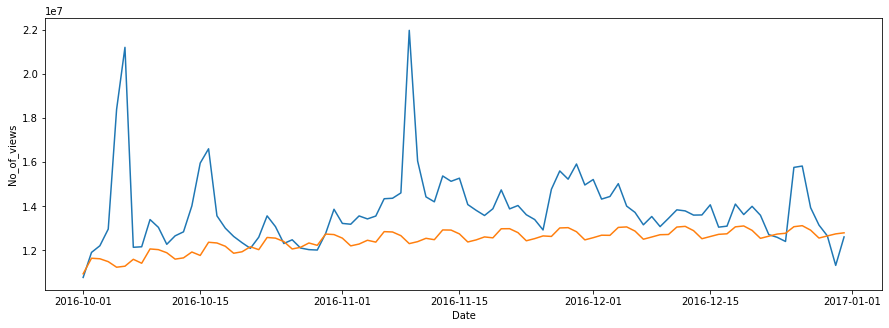

In [190]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_russian.Date, y=test_russian.No_of_views)
sns.lineplot(x=test_russian.Date, y=russian_arima.forecast(len(test_russian)).values)
plt.show()

#### Modelling - SARIMAX

In [191]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

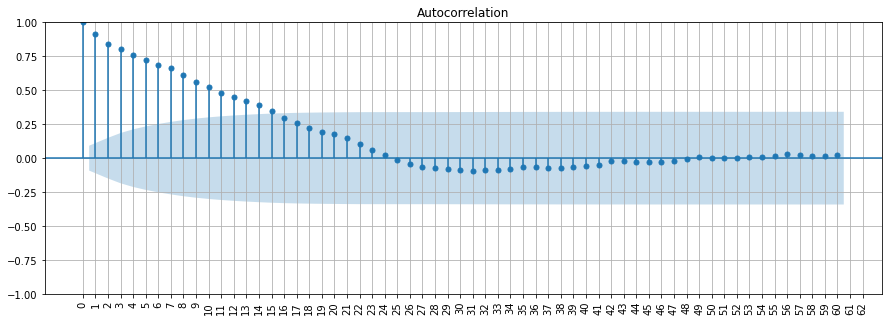

In [192]:
# I cannot clearly see any seasonality here. Assuming weekly seasonality exists.
# Taking only the first 3 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_russian.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

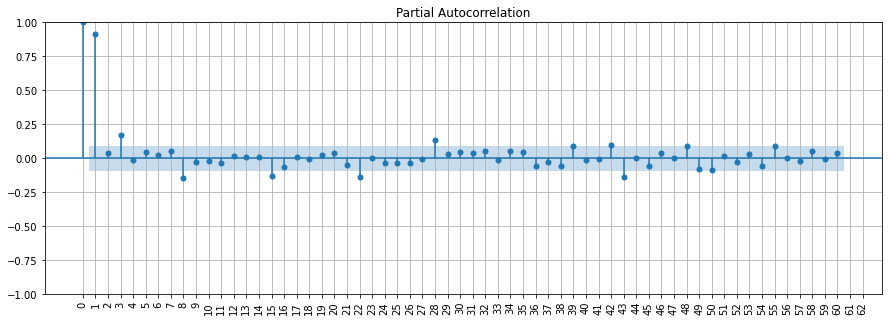

In [193]:
# From this plot, I will take 3 lags for P eventhough multiple of 7 lag dont seem to be significant. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_russian.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [194]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 7(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P': np.arange(1,6,1), 'Q':np.arange(1,6,1)}))

sarimax_mapes = []

for i in range(len(param_grid)):
    russian_sarimax = SARIMAX(train_russian.No_of_views,
                            exog = exog.Campaign[:len(train_russian)], 
                            order=(6, 1, 6), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = russian_sarimax.forecast(steps = len(test_russian), 
                                             exog = exog.Campaign[len(train_russian):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_russian.No_of_views, test_forecast)*100)

In [195]:
# For params (6,1,6) and (2,1,5,7), I could get an MAPE as 11.35% which is actually worse as compared to ARIMA.
# This clearly shows there is almost no seasonality in this time series.
# We are trying to force seasonality lags into the ARIMA equation making it complex and worse.
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 2, 'Q': 5}, 11.359425626491248)

> -  Best MAPE with SARIMAX for test set is 11.35%

In [196]:
# Retraining the sarimax model with the best params
russian_sarimax = SARIMAX(train_russian.No_of_views, 
                          order=(6,1,6), 
                          seasonality_order=(2, 1, 5, 7), 
                          exog = exog.Campaign[:len(train_russian)]).fit(disp=False)
test_forecast = russian_sarimax.forecast(steps = len(test_russian), 
                                             exog = exog.Campaign[len(train_russian):].reset_index(drop=True))

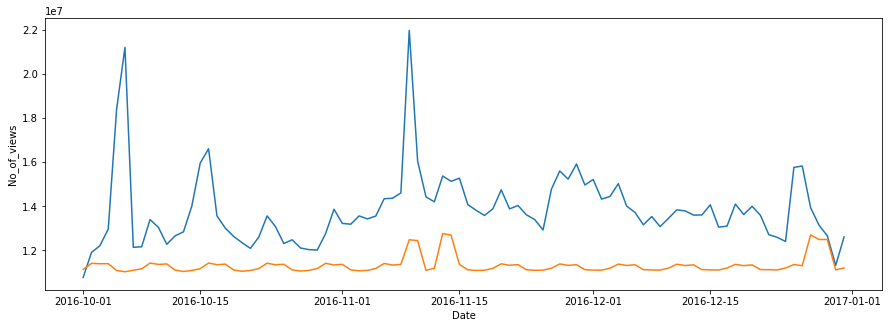

In [197]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_russian.Date, y=test_russian.No_of_views)
sns.lineplot(x=test_russian.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [198]:
# Adding Exogenous variable campaign to train data frame
train_russian['Campaign'] = exog['Campaign'][:train_russian.shape[0]]
train_russian.head()

Date  No_of_views  Campaign
0 2015-07-01   9579392.84         0
1 2015-07-02   9660125.00         0
2 2015-07-03   9579392.84         0
3 2015-07-04   9579392.84         0
4 2015-07-05   9579392.84         0

In [199]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

russian_prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False,interval_width=0.95) 
russian_prophet.fit(train_russian.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = russian_prophet.make_future_dataframe(periods=len(test_russian),freq="D")
future['Campaign'] = exog['Campaign']
forecast = russian_prophet.predict(future)

13:12:45 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


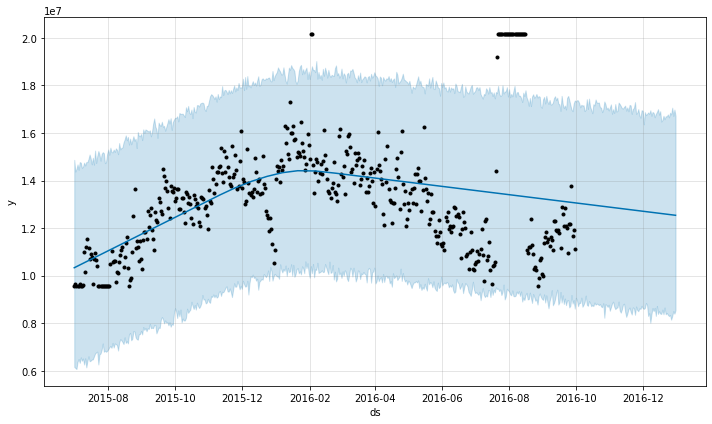

In [200]:
russian_prophet.plot(forecast)
plt.show()

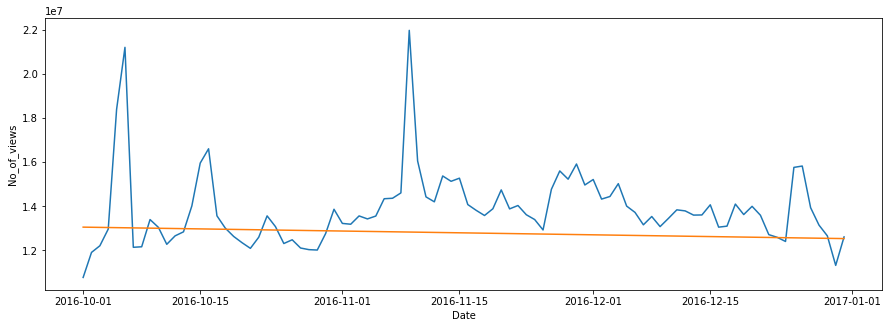

In [201]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_russian.Date, y=test_russian.No_of_views)
sns.lineplot(x=test_russian.Date, y=forecast.iloc[len(train_russian):, :].yhat.values)
plt.show()

In [202]:
# A Prophet model without seasonality gave an MAPE score better than both ARIMA and SARIMAX combined. 
# Setting seasnality to True or Auto gave an MAPE score of 23% which is another indicator of seasonality's absence. 
mean_absolute_percentage_error(test_russian.No_of_views, forecast.iloc[len(train_russian):, :].yhat)*100

9.05288240534882

###  German language time series

In [212]:
# We do not know if the columns are sorted left to right
df_german = df_german.reindex(sorted(df_german.columns), axis=1)
df_german.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
13332        55.0        48.0        44.0        35.0        46.0        41.0   
13333         5.0         3.0         4.0         6.0         3.0         1.0   
13334         4.0         6.0         9.0         7.0         6.0         4.0   
13335         5.0         2.0         6.0         6.0         8.0        11.0   
13336         8.0         6.0        15.0         5.0         5.0         9.0   

       2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
13332        32.0        43.0        40.0        38.0  ...        69.0   
13333         5.0         6.0         6.0        11.0  ...        49.0   
13334         5.0         6.0        13.0        10.0  ...        34.0   
13335         5.0         5.0         6.0        13.0  ...        12.0   
13336        10.0         3.0         9.0         6.0  ...        46.0   

       2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
13332        74.0        34.0        62.0        88.0        57.0        74.0   
13333        43.0        44.0        38.0        31.0        29.0        37.0   
13334        44.0        47.0        46.0        35.0        31.0        31.0   
13335        18.0        13.0        11.0         8.0         8.0        13.0   
13336        32.0        40.0        38.0        29.0        19.0        30.0   

       2016-12-29  2016-12-30  2016-12-31  
13332        61.0        51.0        60.0  
13333        32.0        29.0        34.0  
13334        34.0        28.0        27.0  
13335         5.0        11.0         6.0  
13336        29.0        26.0        26.0  

[5 rows x 550 columns]

In [213]:
df_german.shape

(22844, 550)

In [214]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_german.columns[0], df_german.columns[-1]

('2015-07-01', '2016-12-31')

In [215]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_german.columns[-1]) - pd.to_datetime(df_german.columns[0])).split()[0])+1

550

In [216]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_german.isna().sum(axis=1)

13332       0
13333       0
13334       0
13335       0
13336       0
         ... 
141521    538
141522    544
141523    544
141524    544
141525    550
Length: 22844, dtype: int64

In [217]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_german.isna().sum(axis=1)[df_german.isna().sum(axis=1)/550 >= 0.05].index
df_german.drop(nan_indices, inplace=True)
df_german.isna().sum(axis=1)[df_german.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [219]:
# Filling the missing values page wise using the bfill technique. 
df_german.fillna(method='bfill', axis=1, inplace=True)

In [220]:
# Getting the sum of views of all the pages combined for each date.
df_german = df_german.sum().to_frame(name='No_of_views').rename_axis('Date')
df_german = df_german.reset_index()
df_german['Date'] = pd.to_datetime(df_german.Date) # Converting Date column to date_time 

In [221]:
# We donot have any missing values
df_german.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [222]:
df_german.groupby([df_german.Date.dt.year, df_german.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [223]:
df_german.groupby([df_german.Date.dt.year, df_german.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [224]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_german = df_german.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_german = df_german.set_index('Date').loc['2016-10-01':,:].reset_index()

In [225]:
train_german.shape, test_german.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

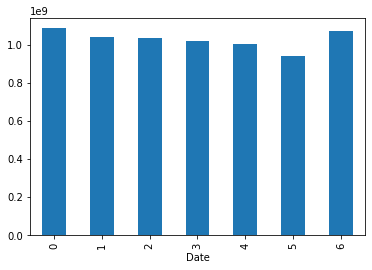

In [226]:
# Comparing total No of views on weekly basis.
# Views on Sundays are higher compared to other days of the week. 
train_german.groupby(train_german.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [227]:
# Getting the first date of every month and also the sundays of every week.
sundays = train_german[(train_german.Date.dt.dayofweek == 0)].Date.values
month_1st_dates =  train_german[(train_german.Date.dt.day == 1)].Date.values

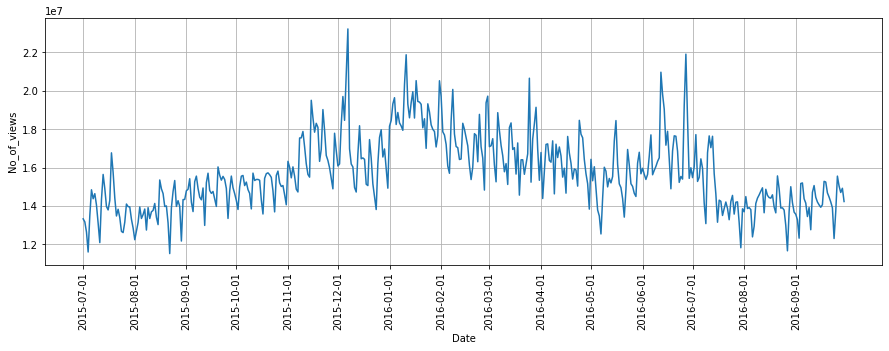

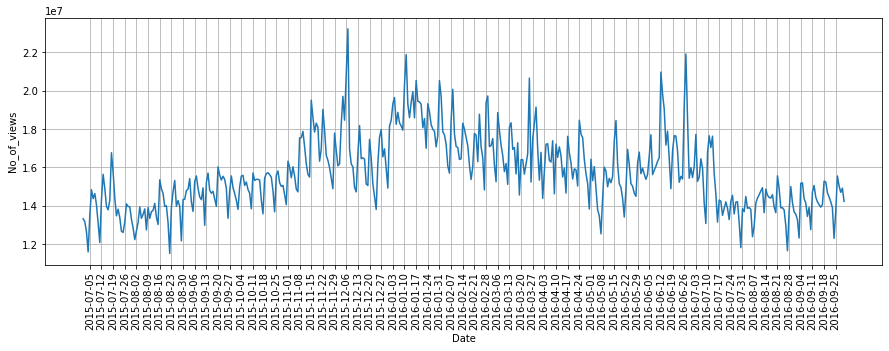

In [228]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_german.Date, train_german.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_german.Date, train_german.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on sundays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [230]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_german.No_of_views)
# P-val = 0.24 which is greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.104145260230427,
 0.24285104184865142,
 16,
 441,
 {'1%': -3.4452655826028318,
  '5%': -2.868116205869215,
  '10%': -2.570272878944473},
 13349.123459694127)

#### Time series decomposition

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose

german_decomp = seasonal_decompose(train_german.set_index('Date'), two_sided=False)

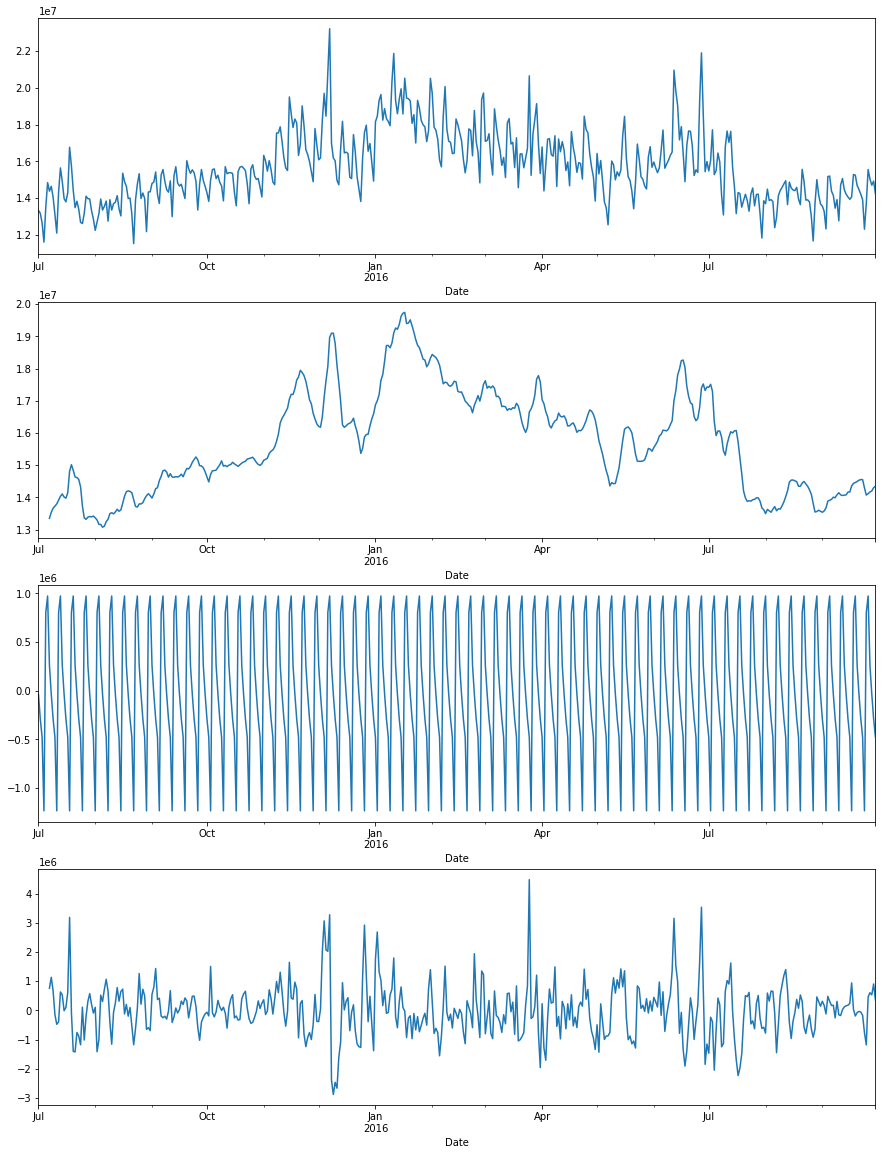

In [232]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
german_decomp.observed.plot()
plt.subplot(4,1,2)
german_decomp.trend.plot()
plt.subplot(4,1,3)
german_decomp.seasonal.plot()
plt.subplot(4,1,4)
german_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [233]:
german_decomp.resid

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
                  ...      
2016-09-26    463062.127487
2016-09-27    608428.485660
2016-09-28    535553.894452
2016-09-29    907458.197748
2016-09-30    360225.885660
Name: resid, Length: 458, dtype: float64

In [234]:
from statsmodels.tsa.stattools import adfuller

adfuller(german_decomp.resid[6:])
# P-val = 7.078561187935457e-16 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-9.378066747679828,
 7.078561187935457e-16,
 7,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 12953.32036255846)

#### Stationary conversion - Detrending

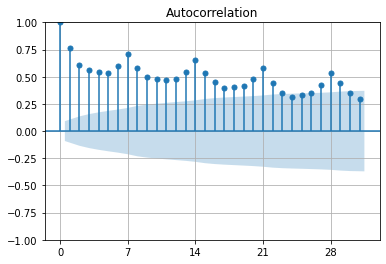

In [235]:
# I can see some good amount of correlation (Coeff > 0.5).  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_german.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [236]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_german.No_of_views.diff()
detrend

0            NaN
1      -157684.0
2      -527539.0
3     -1042092.0
4      1897213.0
         ...    
453    1855800.0
454    -516237.0
455    -336503.0
456     219153.0
457    -689689.0
Name: No_of_views, Length: 458, dtype: float64

In [237]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 1.0768187010320398e-07 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-6.08372422758703,
 1.0768187010320398e-07,
 15,
 441,
 {'1%': -3.4452655826028318,
  '5%': -2.868116205869215,
  '10%': -2.570272878944473},
 13319.561584408473)

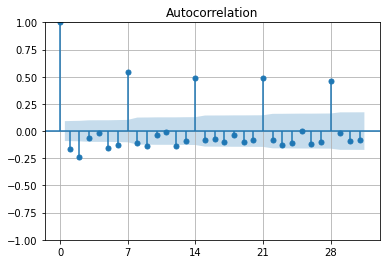

In [238]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

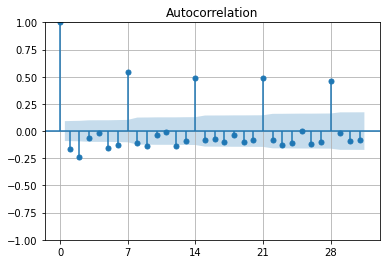

In [239]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

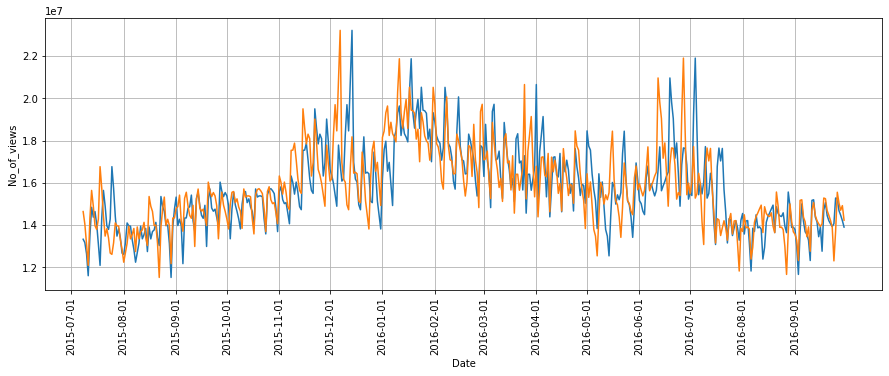

In [240]:
# We can see that almost all the seasonal peaks coincide.
plt.figure(figsize=(15,5))
sns.lineplot(train_german.Date, train_german.No_of_views.shift(7))
sns.lineplot(train_german.Date, train_german.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [241]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8    -434562.0
9    -417407.0
10     30688.0
Name: No_of_views, dtype: float64

In [242]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 6.954822318089026e-19 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-10.57975123988567,
 6.954822318089026e-19,
 14,
 435,
 {'1%': -3.4454725477848998,
  '5%': -2.8682072297316794,
  '10%': -2.570321396485665},
 13125.863240526662)

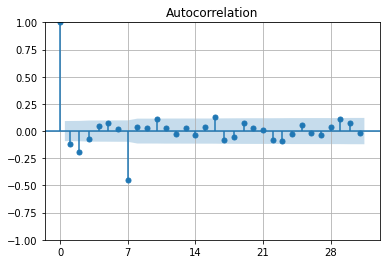

In [243]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

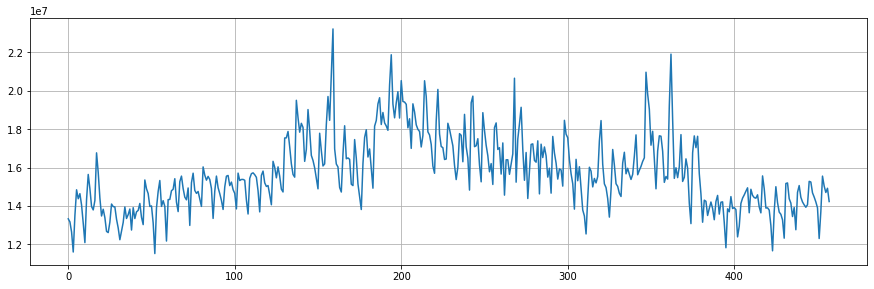

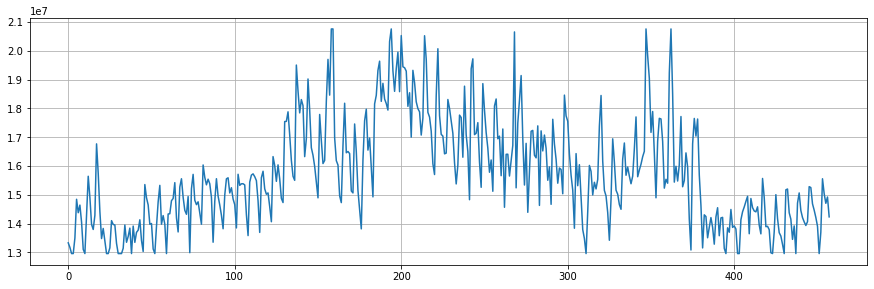

In [245]:
# Clipping the the top 1% and bottom 4% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_german.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_german.No_of_views.clip(upper=train_german.No_of_views.quantile(0.99), 
                               lower=train_german.No_of_views.quantile(0.04)).plot(kind='line')
plt.grid()
plt.show()

In [246]:
# Clipping the anamolies or outliers. Anything below 1 percentine and anything above 99 percentile will be clipeed. 
train_german['No_of_views'] = train_german.No_of_views.clip(upper=train_german.No_of_views.quantile(0.99), 
                               lower=train_german.No_of_views.quantile(0.04))

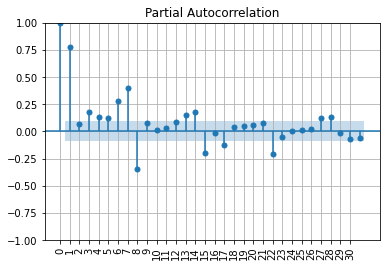

In [247]:
# I can see that some of the lines until 22 lags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 7 or 8 lags as hyperparameters p.
plot_pacf(train_german.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

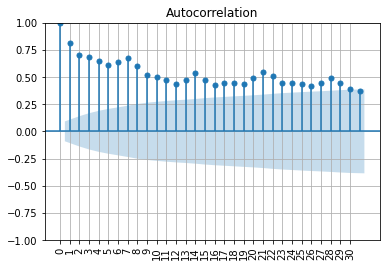

In [278]:
# I can see that some of the lines until 9 lags appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 9 lags as hyperparameters q.
plot_acf(train_german.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [248]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,9), 'q':np.arange(1,10)}))

arima_mapes = []

for i in range(len(param_grid)):
    german_arima = SARIMAX(train_german.No_of_views, 
                           order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_german.No_of_views, 
                                                      german_arima.forecast(len(test_german)))*100)

In [250]:
# For order = (5,1,7), I could get the MAPE as 7.97%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 5, 'q': 7}, 7.9768802823066824)

> -  Best MAPE with ARIMAX for test set is 7.97%

In [252]:
# Retraining the model with the best params for the entire train set.
german_arima = SARIMAX(train_german.No_of_views, order=(5,1,7)).fit(disp=False)

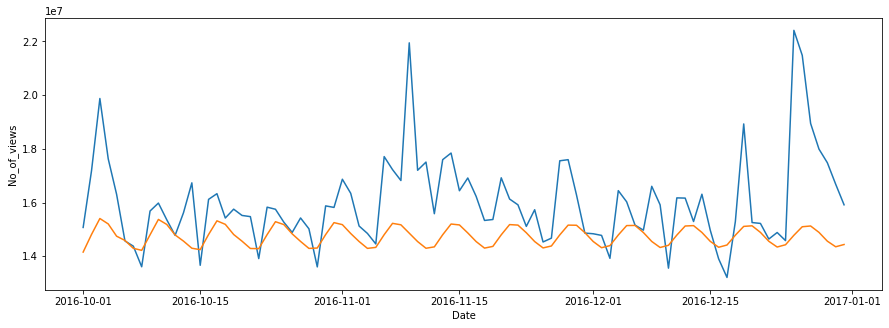

In [253]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_german.Date, y=test_german.No_of_views)
sns.lineplot(x=test_german.Date, y=german_arima.forecast(len(test_german)).values)
plt.show()

#### Modelling - SARIMAX

In [254]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

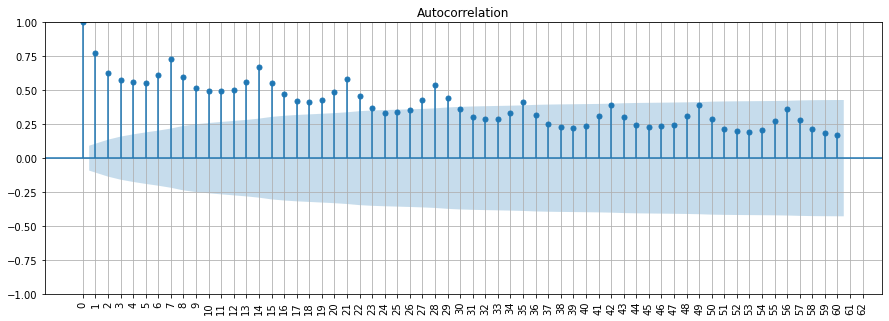

In [255]:
# Some of the seasonal lines (Multiples of 7) appear to be bit significant until 21 as per the confidence intervals. 
# From this plot, I will take the first 4 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_german.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

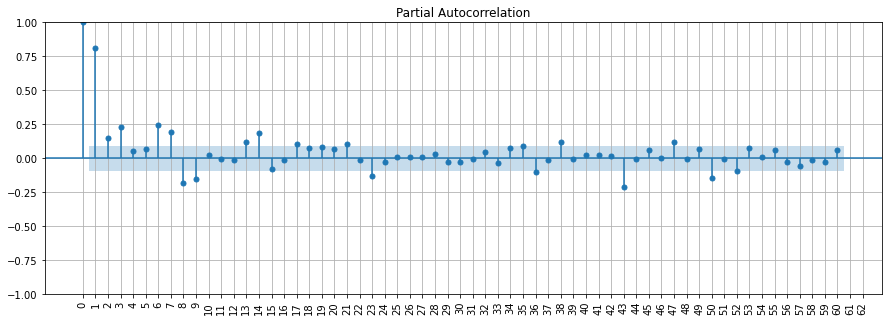

In [290]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_german.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [314]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2, 3], 'Q':[1,2,3,4]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    german_sarimax = SARIMAX(train_german.No_of_views,
                            exog = exog.Campaign[:len(train_german)], 
                            order=(5, 1, 6), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = german_sarimax.forecast(steps = len(test_german), 
                                             exog = exog.Campaign[len(train_german):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_german.No_of_views, test_forecast)*100)

In [315]:
# For params (5,1,6) and (3,1,1,7), I could get an MAPE as 5.64% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 3, 'Q': 1}, 5.646987752320734)

> -  Best MAPE with SARIMAX for test set is 5.64%

In [260]:
# Retraining the sarimax model with the best params
german_sarimax = SARIMAX(train_german.No_of_views, 
                          order=(5,1,6), 
                          seasonality_order=(3, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_german)]).fit(disp=False)
test_forecast = german_sarimax.forecast(steps = len(test_german), 
                                             exog = exog.Campaign[len(train_german):].reset_index(drop=True))

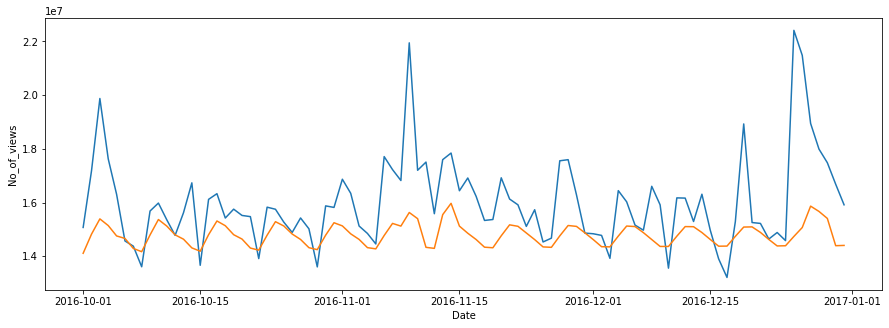

In [261]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_german.Date, y=test_german.No_of_views)
sns.lineplot(x=test_german.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [262]:
# Adding Exogenous variable campaign to train data frame
train_german['Campaign'] = exog['Campaign'][:train_german.shape[0]]
train_german.head()

Date  No_of_views  Campaign
0 2015-07-01   13329052.0         0
1 2015-07-02   13171368.0         0
2 2015-07-03   12956722.6         0
3 2015-07-04   12956722.6         0
4 2015-07-05   13498950.0         0

In [263]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

german_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(german_prophet, 'Campaign')
german_prophet.fit(train_german.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = german_prophet.make_future_dataframe(periods=len(test_german),freq="D")
future['Campaign'] = exog['Campaign']
forecast = german_prophet.predict(future)

17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing


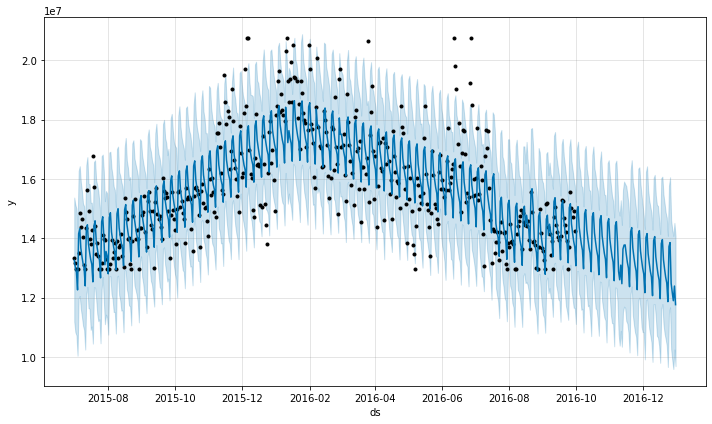

In [264]:
german_prophet.plot(forecast)
plt.show()

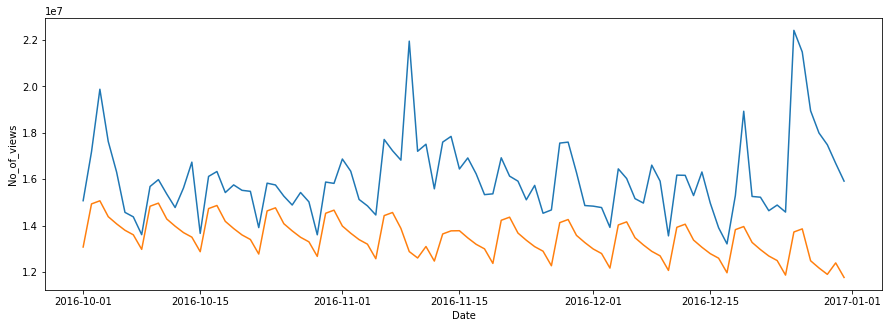

In [265]:
# I dont find any improvement here. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_german.Date, y=test_german.No_of_views)
sns.lineplot(x=test_german.Date, y=forecast.iloc[len(train_german):, :].yhat.values)
plt.show()

In [266]:
# We got 15.31% MAPE which is actually very bad as compared to SARIMAX.
mean_absolute_percentage_error(test_german.No_of_views, forecast.iloc[len(train_german):, :].yhat)*100

15.317170484819284

###  Japanese language time series

In [267]:
# We do not know if the columns are sorted left to right
df_japanese = df_japanese.reindex(sorted(df_japanese.columns), axis=1)
df_japanese.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
55714       102.0       115.0       851.0       568.0       294.0       229.0   
55715      2366.0      1473.0      2292.0      1644.0      1315.0       905.0   
55716        63.0        68.0        53.0        81.0        60.0        56.0   
55717       297.0       264.0       286.0       456.0       500.0       256.0   
55718         0.0         3.0         1.0         1.0         0.0         0.0   

       2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
55714       145.0       126.0       173.0       699.0  ...       181.0   
55715       733.0      1367.0      1152.0       998.0  ...       585.0   
55716        48.0        38.0        47.0        36.0  ...        91.0   
55717       262.0       402.0       271.0       236.0  ...       525.0   
55718         1.0         2.0         1.0         NaN  ...      1152.0   

       2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
55714      1032.0       283.0       170.0       157.0       115.0       117.0   
55715       940.0       679.0       678.0       597.0       785.0       721.0   
55716       216.0       200.0       170.0        98.0        88.0       105.0   
55717       667.0      6941.0      1415.0       922.0       777.0       652.0   
55718      1460.0      1244.0      1315.0       904.0       939.0      2062.0   

       2016-12-29  2016-12-30  2016-12-31  
55714       140.0       155.0       159.0  
55715       667.0       698.0      3824.0  
55716        98.0        80.0       181.0  
55717       579.0       554.0       400.0  
55718      1324.0      2254.0      1089.0  

[5 rows x 550 columns]

In [268]:
df_japanese.shape

(20431, 550)

In [269]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_japanese.columns[0], df_japanese.columns[-1]

('2015-07-01', '2016-12-31')

In [270]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_japanese.columns[-1]) - pd.to_datetime(df_japanese.columns[0])).split()[0])+1

550

In [271]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_japanese.isna().sum(axis=1)

55714       0
55715       0
55716       0
55717       0
55718      21
         ... 
136935    550
136936    550
136937    550
136938    550
136939    550
Length: 20431, dtype: int64

In [272]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_japanese.isna().sum(axis=1)[df_japanese.isna().sum(axis=1)/550 >= 0.05].index
df_japanese.drop(nan_indices, inplace=True)
df_japanese.isna().sum(axis=1)[df_japanese.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [273]:
df_japanese.shape

(18670, 550)

In [274]:
# Filling the missing values page wise using the bfill technique. 
df_japanese.fillna(method='bfill', axis=1, inplace=True)

In [275]:
# Getting the sum of views of all the pages combined for each date.
df_japanese = df_japanese.sum().to_frame(name='No_of_views').rename_axis('Date')
df_japanese = df_japanese.reset_index()
df_japanese['Date'] = pd.to_datetime(df_japanese.Date) # Converting Date column to date_time 

In [276]:
# We donot have any missing values
df_japanese.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [277]:
df_japanese.groupby([df_japanese.Date.dt.year, df_japanese.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [278]:
df_japanese.groupby([df_japanese.Date.dt.year, df_japanese.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [279]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_japanese = df_japanese.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_japanese = df_japanese.set_index('Date').loc['2016-10-01':,:].reset_index()

In [280]:
train_japanese.shape, test_japanese.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

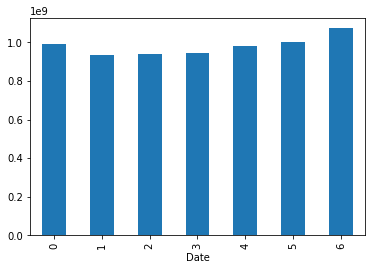

In [281]:
# Comparing total No of views on weekly basis.
# Views on saturdays are higher compared to other days of the week. 
train_japanese.groupby(train_japanese.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [282]:
# Getting the first date of every month and also the sundays of every week.
saturdays = train_japanese[(train_japanese.Date.dt.dayofweek == 6)].Date.values
month_1st_dates =  train_japanese[(train_japanese.Date.dt.day == 1)].Date.values

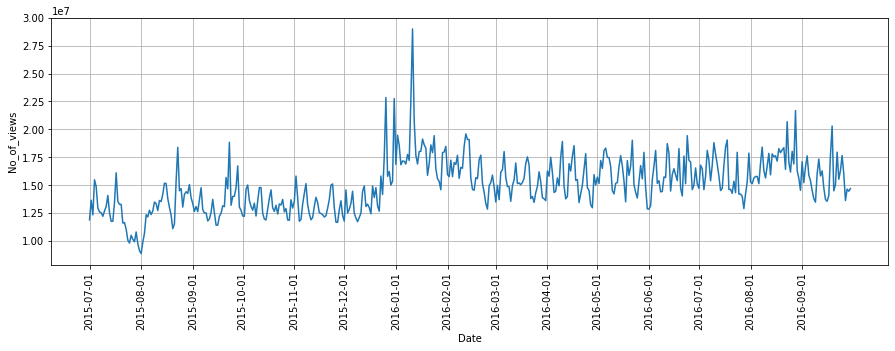

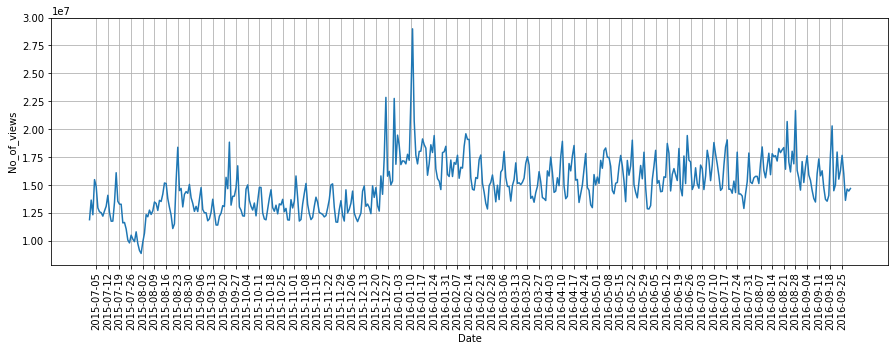

In [283]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_japanese.Date, train_japanese.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_japanese.Date, train_japanese.No_of_views)
plt.xticks(saturdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on sundays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [285]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_japanese.No_of_views)
# P-val = 0.12 which is greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.465808922049567,
 0.12401652502246285,
 6,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 13731.730577534287)

#### Time series decomposition

In [286]:
from statsmodels.tsa.seasonal import seasonal_decompose

japanese_decomp = seasonal_decompose(train_japanese.set_index('Date'), two_sided=False)

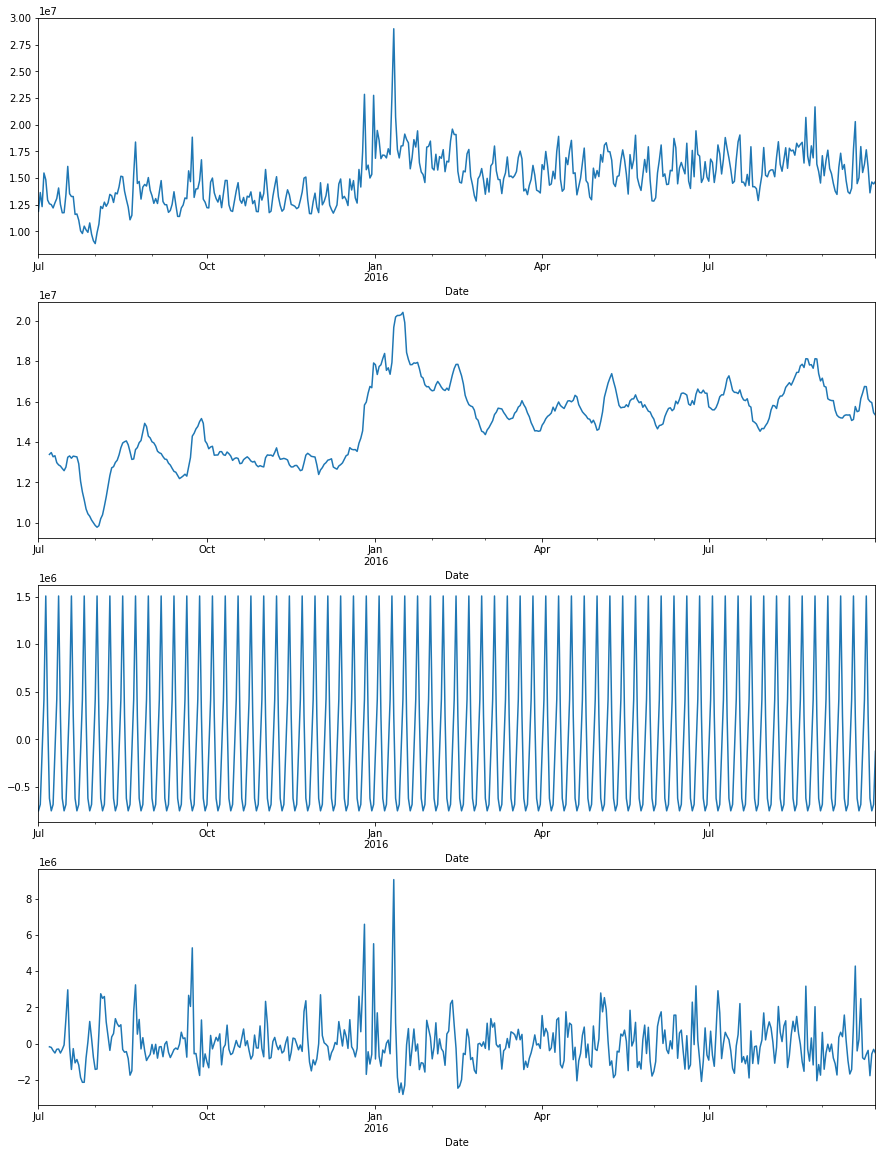

In [287]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
japanese_decomp.observed.plot()
plt.subplot(4,1,2)
japanese_decomp.trend.plot()
plt.subplot(4,1,3)
japanese_decomp.seasonal.plot()
plt.subplot(4,1,4)
japanese_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [288]:
japanese_decomp.resid

Date
2015-07-01             NaN
2015-07-02             NaN
2015-07-03             NaN
2015-07-04             NaN
2015-07-05             NaN
                  ...     
2016-09-26   -3.760093e+05
2016-09-27   -1.776101e+06
2016-09-28   -5.741124e+05
2016-09-29   -3.204192e+05
2016-09-30   -5.273289e+05
Name: resid, Length: 458, dtype: float64

In [290]:
from statsmodels.tsa.stattools import adfuller

adfuller(japanese_decomp.resid[6:])
# P-val = 2.2352475090555457e-13 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-8.400721341118802,
 2.2352475090555457e-13,
 6,
 445,
 {'1%': -3.4451307246616514,
  '5%': -2.86805689169311,
  '10%': -2.570241263729327},
 13356.943227692529)

#### Stationary conversion - Detrending

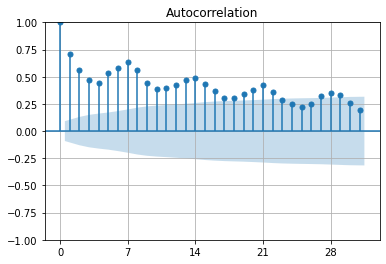

In [291]:
# I can see some good amount of correlation (Coeff > 0.5).  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_japanese.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [292]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_japanese.No_of_views.diff()
detrend

0            NaN
1      1758937.0
2     -1319430.0
3      3151867.0
4      -627605.0
         ...    
453   -1646950.0
454   -2389394.0
455    1014367.0
456    -179454.0
457     230863.0
Name: No_of_views, Length: 458, dtype: float64

In [293]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 4.388988623391612e-30 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-17.500319876241434,
 4.388988623391612e-30,
 5,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 13705.508028618411)

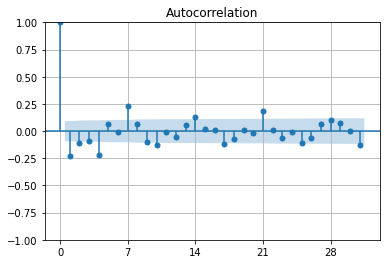

In [294]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

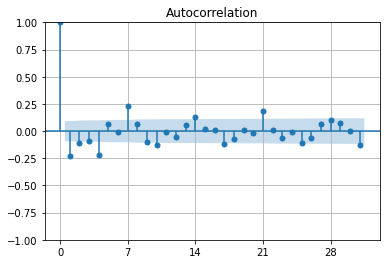

In [295]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

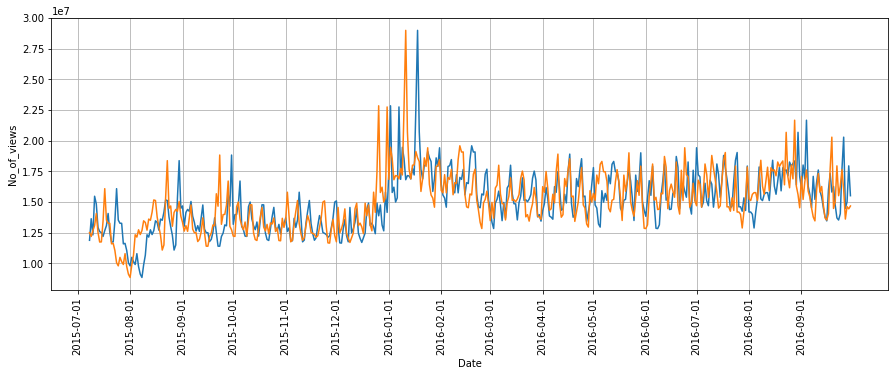

In [296]:
# We can see that almost all the seasonal peaks coincide.
plt.figure(figsize=(15,5))
sns.lineplot(train_japanese.Date, train_japanese.No_of_views.shift(7))
sns.lineplot(train_japanese.Date, train_japanese.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [297]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8    -2073742.0
9     1793969.0
10   -2742684.0
Name: No_of_views, dtype: float64

In [298]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 6.954822318089026e-19 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-7.494648882642588,
 4.412308627757119e-11,
 18,
 431,
 {'1%': -3.445613745346461,
  '5%': -2.868269325317112,
  '10%': -2.5703544951308404},
 13571.214902771435)

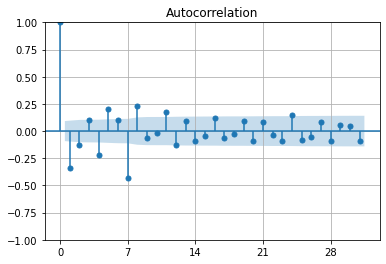

In [299]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

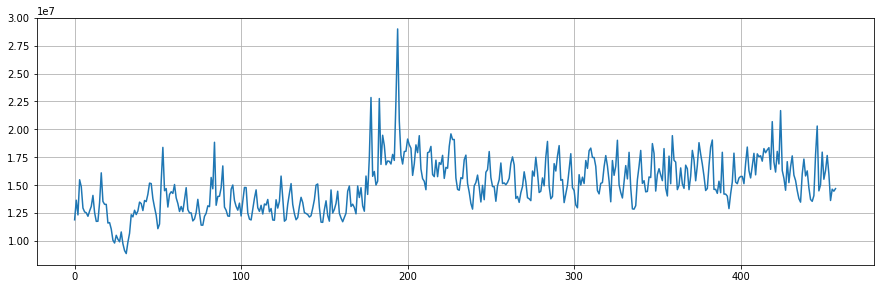

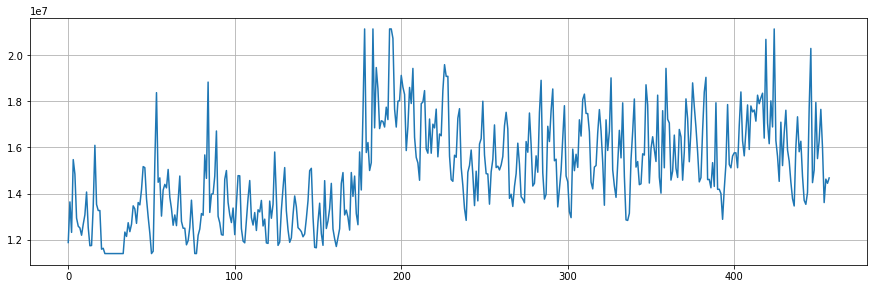

In [303]:
# Clipping the the top 1% and bottom 3% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_japanese.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_japanese.No_of_views.clip(upper=train_japanese.No_of_views.quantile(0.99), 
                               lower=train_japanese.No_of_views.quantile(0.03)).plot(kind='line')
plt.grid()
plt.show()

In [304]:
# Clipping the anamolies or outliers. 
train_japanese['No_of_views'] = train_japanese.No_of_views.clip(upper=train_japanese.No_of_views.quantile(0.99), 
                               lower=train_japanese.No_of_views.quantile(0.03))

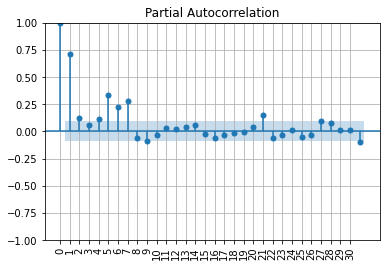

In [305]:
# I can see that some of thelags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 7 lags as hyperparameters p.
plot_pacf(train_japanese.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

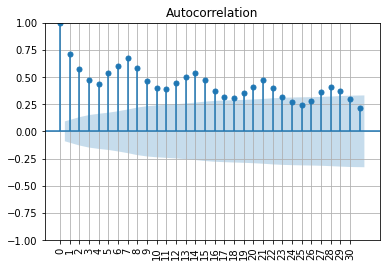

In [306]:
# I can see that some of the lines appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 6 lags as hyperparameters q.
plot_acf(train_japanese.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [307]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,8), 'q':np.arange(1,7)}))

arima_mapes = []

for i in range(len(param_grid)):
    japanese_arima = SARIMAX(train_japanese.No_of_views, 
                             order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_japanese.No_of_views, 
                                                      japanese_arima.forecast(len(test_japanese)))*100)

In [308]:
# For order = (5,1,3), I could get the MAPE as 6.91%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 5, 'q': 3}, 6.910055208442029)

> -  Best MAPE with ARIMAX for test set is 6.91%

In [309]:
# Retraining the model with the best params for the entire train set.
japanese_arima = SARIMAX(train_japanese.No_of_views, order=(5,1,3)).fit(disp=False)

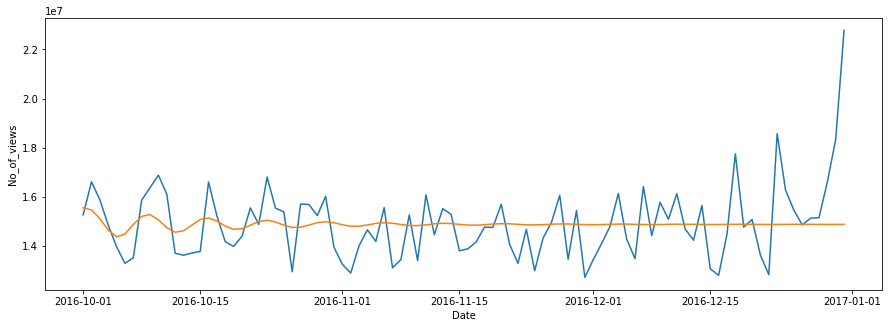

In [310]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_japanese.Date, y=test_japanese.No_of_views)
sns.lineplot(x=test_japanese.Date, y=japanese_arima.forecast(len(test_japanese)).values)
plt.show()

#### Modelling - SARIMAX

In [311]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

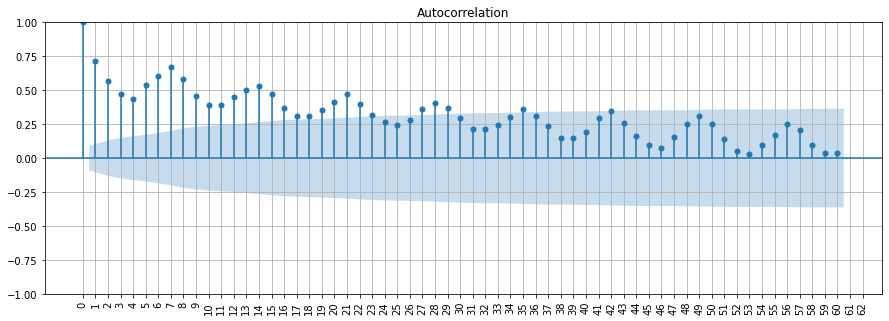

In [312]:
# Some of the seasonal lines (Multiples of 7) appear to be bit as per the confidence intervals. 
# From this plot, I will take the first 4 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_japanese.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

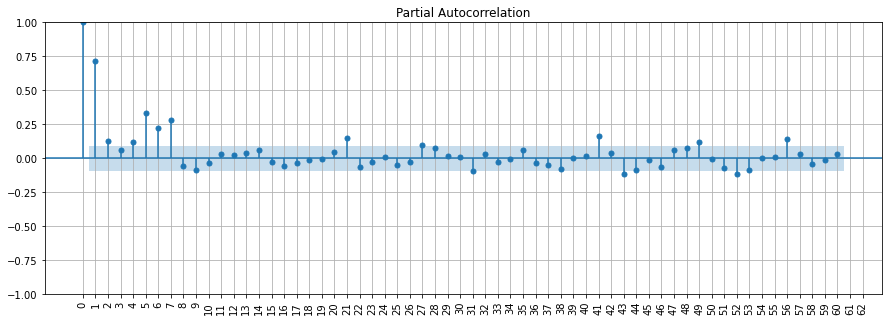

In [313]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_japanese.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [316]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2, 3], 'Q':[1,2,3,4]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    japanese_sarimax = SARIMAX(train_japanese.No_of_views,
                            exog = exog.Campaign[:len(train_japanese)], 
                            order=(5, 1, 3), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = japanese_sarimax.forecast(steps = len(test_japanese), 
                                             exog = exog.Campaign[len(train_japanese):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_japanese.No_of_views, test_forecast)*100)

In [318]:
# For params (5,1,3) and (1,1,1,7), I could get an MAPE as 5.69% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 1, 'Q': 1}, 5.697074425639745)

> -  Best MAPE with SARIMAX for test set is 5.69%

In [319]:
# Retraining the sarimax model with the best params
japanese_sarimax = SARIMAX(train_japanese.No_of_views, 
                          order=(5,1,3), 
                          seasonality_order=(1, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_japanese)]).fit(disp=False)
test_forecast = japanese_sarimax.forecast(steps = len(test_japanese), 
                                             exog = exog.Campaign[len(train_japanese):].reset_index(drop=True))

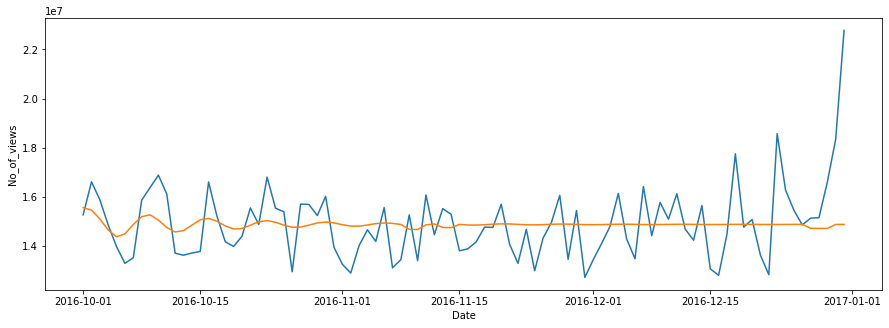

In [320]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_japanese.Date, y=test_japanese.No_of_views)
sns.lineplot(x=test_japanese.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [321]:
# Adding Exogenous variable campaign to train data frame
train_japanese['Campaign'] = exog['Campaign'][:train_japanese.shape[0]]
train_japanese.head()

Date  No_of_views  Campaign
0 2015-07-01   11883893.0         0
1 2015-07-02   13642830.0         0
2 2015-07-03   12323400.0         0
3 2015-07-04   15475267.0         0
4 2015-07-05   14847662.0         0

In [322]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

japanese_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(japanese_prophet, 'Campaign')
japanese_prophet.fit(train_japanese.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = japanese_prophet.make_future_dataframe(periods=len(test_japanese),freq="D")
future['Campaign'] = exog['Campaign']
forecast = japanese_prophet.predict(future)

18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing


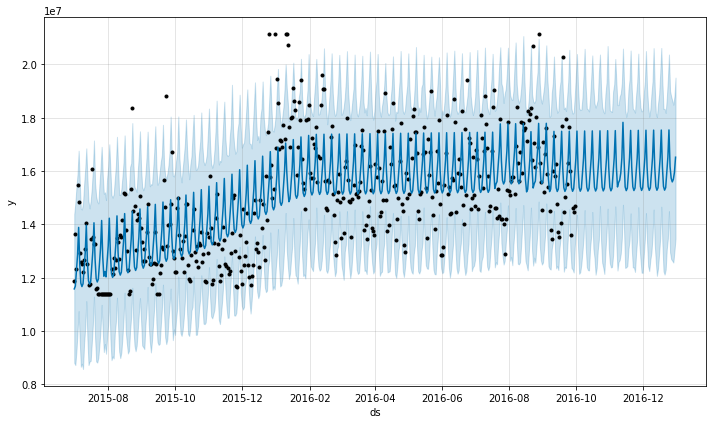

In [323]:
japanese_prophet.plot(forecast)
plt.show()

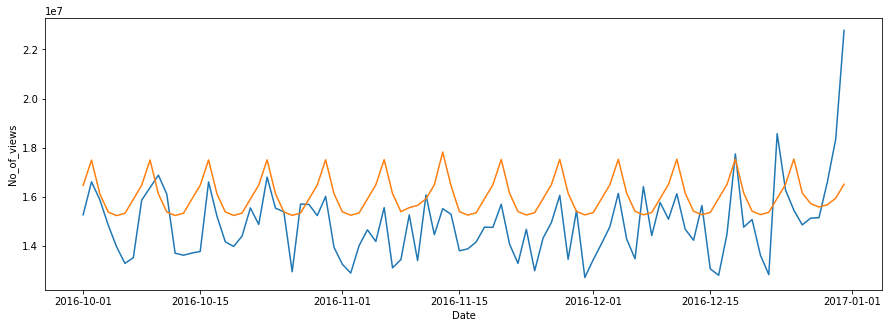

In [324]:
# I dont find any improvement here. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_japanese.Date, y=test_japanese.No_of_views)
sns.lineplot(x=test_japanese.Date, y=forecast.iloc[len(train_japanese):, :].yhat.values)
plt.show()

In [325]:
# We got 10.07% MAPE which is actually bad as compared to SARIMAX.
mean_absolute_percentage_error(test_japanese.No_of_views, forecast.iloc[len(train_japanese):, :].yhat)*100

10.076491449056348

###  Spanish language time series

In [326]:
# We do not know if the columns are sorted left to right
df_spanish = df_spanish.reindex(sorted(df_spanish.columns), axis=1)
df_spanish.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
69479       390.0       393.0       291.0       221.0       238.0      1121.0   
69480         NaN         NaN         NaN         NaN         NaN         NaN   
69481        99.0        90.0        65.0        79.0        75.0       116.0   
69482        77.0        66.0        61.0        53.0        55.0        59.0   
69483        90.0       155.0        91.0        47.0        82.0       114.0   

       2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
69479       294.0       333.0       366.0       290.0  ...        78.0   
69480         NaN         NaN         NaN         NaN  ...       215.0   
69481       109.0       138.0       105.0       141.0  ...        66.0   
69482       122.0       126.0        96.0        95.0  ...        21.0   
69483        89.0       100.0        60.0        89.0  ...        43.0   

       2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
69479       224.0        34.0       188.0        65.0        81.0        66.0   
69480       253.0       279.0       295.0       384.0       374.0       409.0   
69481       216.0        62.0        32.0        92.0        48.0       226.0   
69482        29.0        27.0       181.0        31.0        39.0       197.0   
69483        47.0       193.0        29.0        43.0        50.0        47.0   

       2016-12-29  2016-12-30  2016-12-31  
69479       239.0        88.0        59.0  
69480       394.0       432.0       317.0  
69481        67.0        44.0        46.0  
69482        42.0        39.0        40.0  
69483        56.0        49.0        57.0  

[5 rows x 550 columns]

In [327]:
df_spanish.shape

(14069, 550)

In [328]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_spanish.columns[0], df_spanish.columns[-1]

('2015-07-01', '2016-12-31')

In [329]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_spanish.columns[-1]) - pd.to_datetime(df_spanish.columns[0])).split()[0])+1

550

In [330]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_spanish.isna().sum(axis=1)

69479       0
69480     206
69481       0
69482       0
69483       0
         ... 
145058    544
145059    550
145060    550
145061    550
145062    550
Length: 14069, dtype: int64

In [331]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_spanish.isna().sum(axis=1)[df_spanish.isna().sum(axis=1)/550 >= 0.05].index
df_spanish.drop(nan_indices, inplace=True)
df_spanish.isna().sum(axis=1)[df_spanish.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [333]:
df_spanish.shape

(12978, 550)

In [334]:
# Filling the missing values page wise using the bfill technique. 
df_spanish.fillna(method='bfill', axis=1, inplace=True)

In [335]:
# Getting the sum of views of all the pages combined for each date.
df_spanish = df_spanish.sum().to_frame(name='No_of_views').rename_axis('Date')
df_spanish = df_spanish.reset_index()
df_spanish['Date'] = pd.to_datetime(df_spanish.Date) # Converting Date column to date_time 

In [336]:
# We donot have any missing values
df_spanish.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [337]:
df_spanish.groupby([df_spanish.Date.dt.year, df_spanish.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [338]:
df_spanish.groupby([df_spanish.Date.dt.year, df_spanish.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [339]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_spanish = df_spanish.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_spanish = df_spanish.set_index('Date').loc['2016-10-01':,:].reset_index()

In [340]:
train_spanish.shape, test_spanish.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

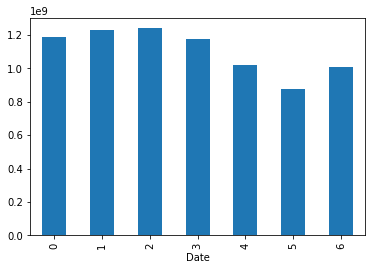

In [341]:
# Comparing total No of views on weekly basis.
# Views on Tuesdays are higher compared to other days of the week. 
train_spanish.groupby(train_spanish.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [342]:
# Getting the first date of every month and also the sundays of every week.
tuesdays = train_spanish[(train_spanish.Date.dt.dayofweek == 2)].Date.values
month_1st_dates =  train_spanish[(train_spanish.Date.dt.day == 1)].Date.values

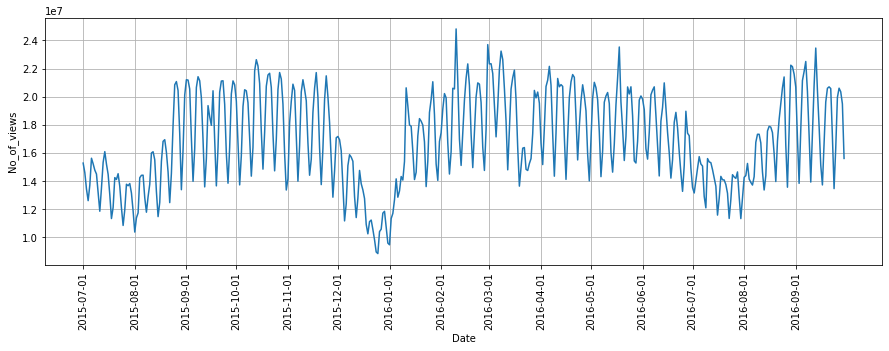

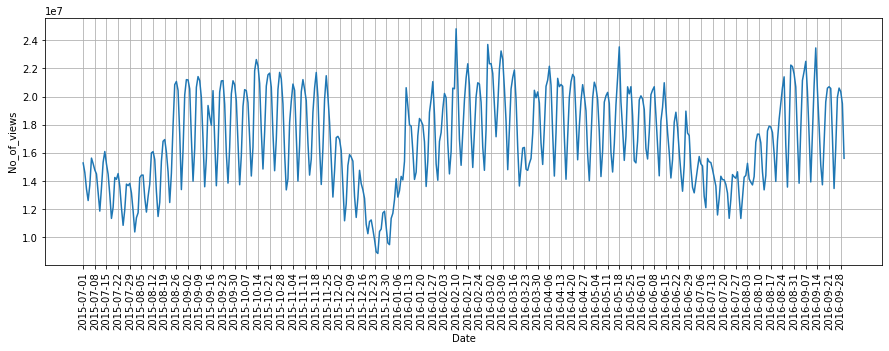

In [343]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_spanish.Date, train_spanish.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_spanish.Date, train_spanish.No_of_views)
plt.xticks(tuesdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on tuesdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [345]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_spanish.No_of_views)
# P-val = 0.02 which is lesser than 0.05.
# We reject null hypothesis. Hence, time series is stationary.

(-3.1391478186366375,
 0.02378848402319052,
 15,
 442,
 {'1%': -3.445231637930579,
  '5%': -2.8681012763264233,
  '10%': -2.5702649212751583},
 13386.643037236025)

#### Time series decomposition

In [346]:
from statsmodels.tsa.seasonal import seasonal_decompose

spanish_decomp = seasonal_decompose(train_spanish.set_index('Date'), two_sided=False)

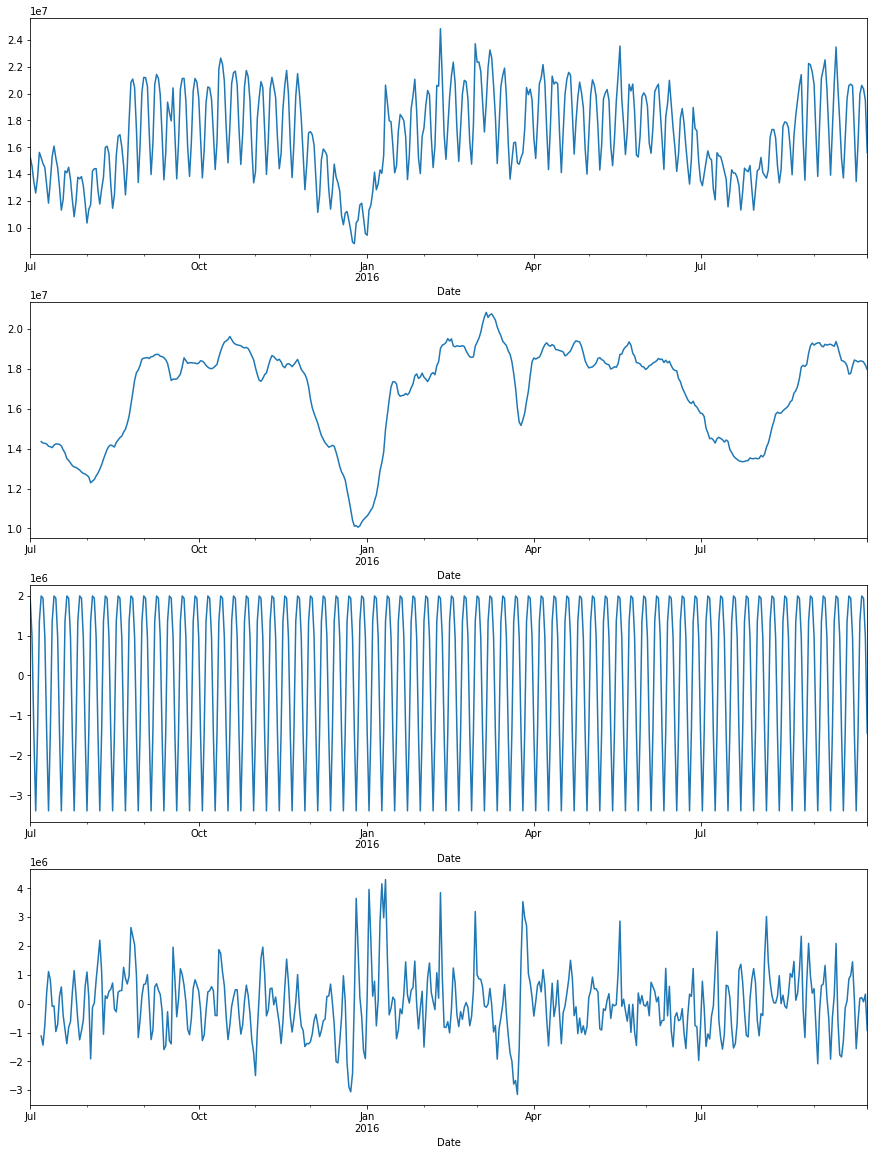

In [347]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
spanish_decomp.observed.plot()
plt.subplot(4,1,2)
spanish_decomp.trend.plot()
plt.subplot(4,1,3)
spanish_decomp.seasonal.plot()
plt.subplot(4,1,4)
spanish_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [348]:
spanish_decomp.resid

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
                  ...      
2016-09-26    191144.365895
2016-09-27    214745.126918
2016-09-28     67872.896149
2016-09-29    332782.904940
2016-09-30   -918147.963192
Name: resid, Length: 458, dtype: float64

In [350]:
from statsmodels.tsa.stattools import adfuller

adfuller(spanish_decomp.resid[6:])
# P-val = 0.00015454540109498328 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-4.5575625923239595,
 0.00015454540109498328,
 12,
 439,
 {'1%': -3.4453339386510784,
  '5%': -2.868146269723016,
  '10%': -2.5702889034926137},
 13031.960773200732)

#### Stationary conversion - Detrending

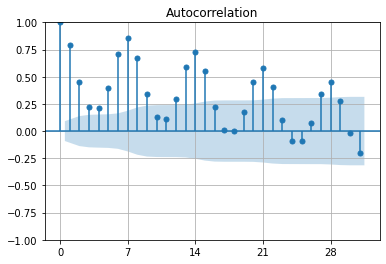

In [351]:
# I can see some good amount of correlation (Coeff > 0.5).  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_spanish.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [352]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_spanish.No_of_views.diff()
detrend

0            NaN
1      -676567.0
2     -1172427.0
3      -821078.0
4      1102642.0
         ...    
453    3609419.0
454     656720.0
455    -253271.0
456    -861906.0
457   -3876906.0
Name: No_of_views, Length: 458, dtype: float64

In [354]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 4.0321216076176045e-05 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-4.86753017275111,
 4.0321216076176045e-05,
 14,
 442,
 {'1%': -3.445231637930579,
  '5%': -2.8681012763264233,
  '10%': -2.5702649212751583},
 13366.037699904675)

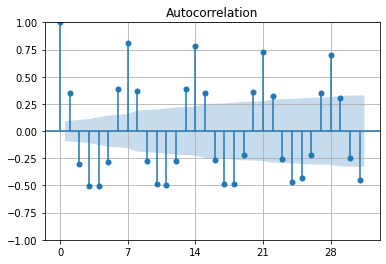

In [355]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

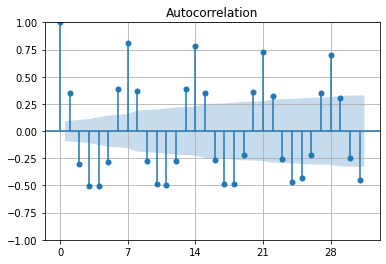

In [356]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

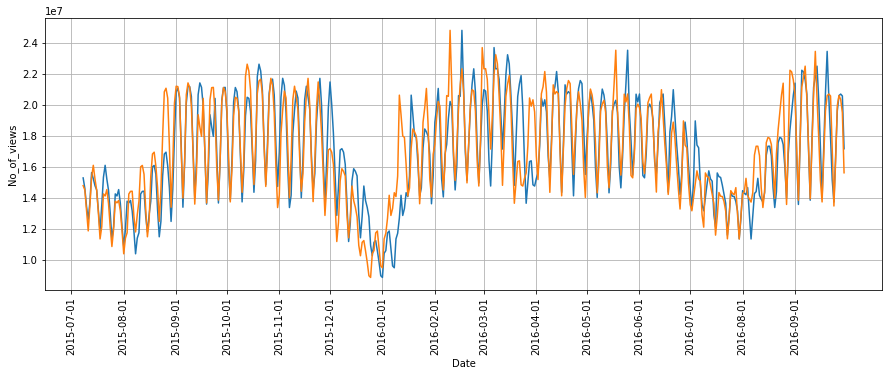

In [357]:
# We can see that almost all the seasonal peaks coincide.
plt.figure(figsize=(15,5))
sns.lineplot(train_spanish.Date, train_spanish.No_of_views.shift(7))
sns.lineplot(train_spanish.Date, train_spanish.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [358]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8     396736.0
9    -147612.0
10   -503294.0
Name: No_of_views, dtype: float64

In [359]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 1.4637244489678938e-10 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-7.285354848674387,
 1.4637244489678938e-10,
 17,
 432,
 {'1%': -3.445578199334947,
  '5%': -2.8682536932290876,
  '10%': -2.570346162765775},
 13204.191180729538)

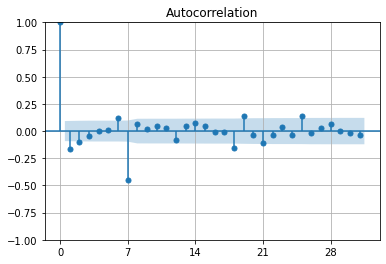

In [360]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

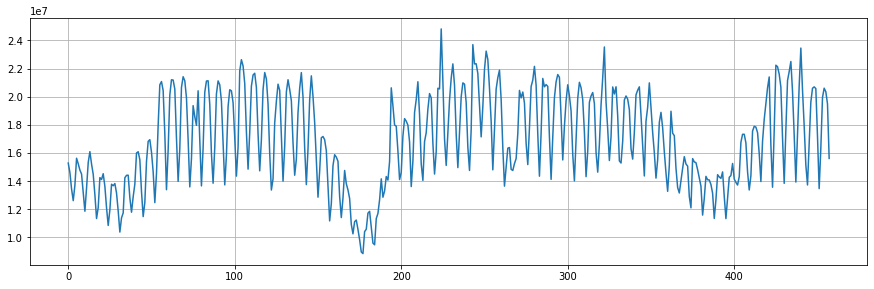

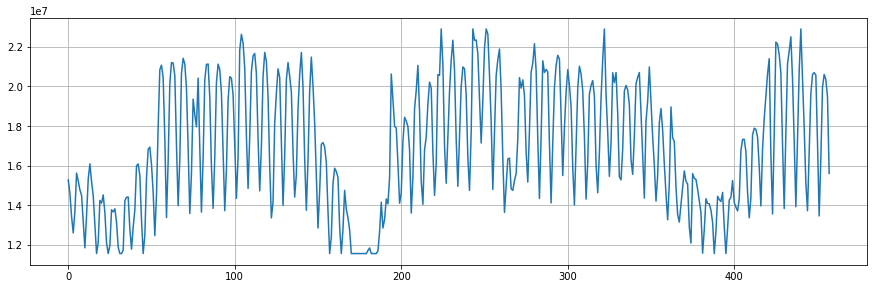

In [367]:
# Clipping the the top 1% and bottom 5% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_spanish.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_spanish.No_of_views.clip(upper=train_spanish.No_of_views.quantile(0.99), 
                               lower=train_spanish.No_of_views.quantile(0.05)).plot(kind='line')
plt.grid()
plt.show()

In [368]:
# Clipping the anamolies or outliers. 
train_spanish['No_of_views'] = train_spanish.No_of_views.clip(upper=train_spanish.No_of_views.quantile(0.99), 
                               lower=train_spanish.No_of_views.quantile(0.05))

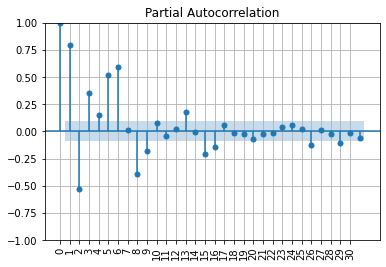

In [369]:
# I can see that some of thelags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 6 lags as hyperparameters p.
plot_pacf(train_spanish.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

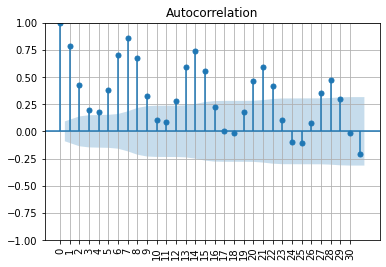

In [370]:
# I can see that some of the lines appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 6 lags as hyperparameters q.
plot_acf(train_spanish.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [384]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 or 2.
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,7), 'q':np.arange(1,7)}))

arima_mapes = []

for i in range(len(param_grid)):
    spanish_arima = SARIMAX(train_spanish.No_of_views, 
                             order=(param_grid[i]['p'], 2, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_spanish.No_of_views, 
                                                      spanish_arima.forecast(len(test_spanish)))*100)

In [393]:
# For order = (5,2,1), I could get the MAPE as 11.86%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 5, 'q': 1}, 11.867796308402891)

> -  Best MAPE with ARIMAX for test set is 11.86%

In [394]:
# Retraining the model with the best params for the entire train set.
spanish_arima = SARIMAX(train_spanish.No_of_views, order=(5,2,1)).fit(disp=False)

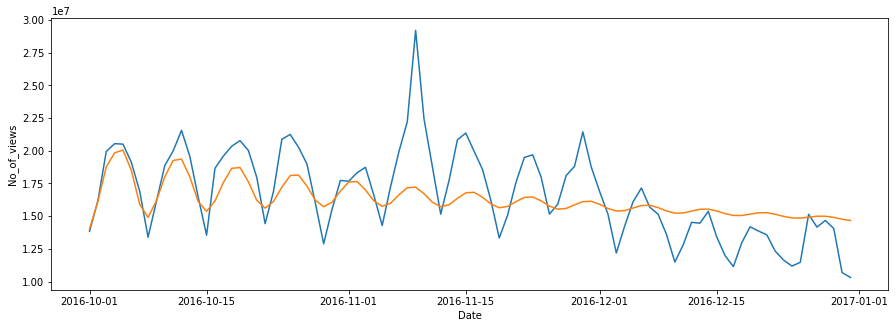

In [395]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_spanish.Date, y=test_spanish.No_of_views)
sns.lineplot(x=test_spanish.Date, y=spanish_arima.forecast(len(test_spanish)).values)
plt.show()

#### Modelling - SARIMAX

In [389]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

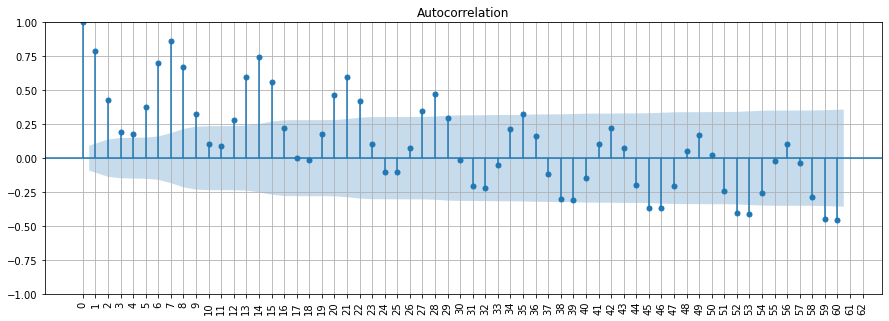

In [390]:
# Some of the seasonal lines (Multiples of 7) appear to be bit as per the confidence intervals. 
# From this plot, I will take the first 4 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_spanish.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

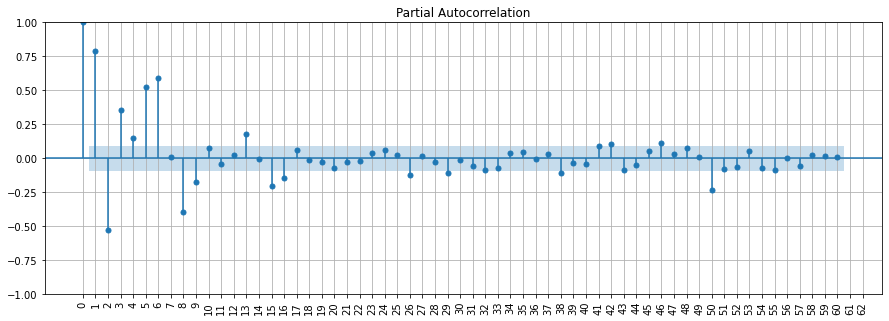

In [392]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P.
# I dont see any lag being significant but still taking 3. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_spanish.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [401]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2, 3], 'Q':[1,2,3,4]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    spanish_sarimax = SARIMAX(train_spanish.No_of_views,
                            exog = exog.Campaign[:len(train_spanish)], 
                            order=(5, 2, 1), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = spanish_sarimax.forecast(steps = len(test_spanish), 
                                             exog = exog.Campaign[len(train_spanish):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_spanish.No_of_views, test_forecast)*100)

In [402]:
# For params (5,2,1) and (1,1,1,7), I could get an MAPE as 10.09% which is an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 1, 'Q': 1}, 10.09947677901575)

> -  Best MAPE with SARIMAX for test set is 10.09%

In [403]:
# Retraining the sarimax model with the best params
spanish_sarimax = SARIMAX(train_spanish.No_of_views, 
                          order=(5,2,1), 
                          seasonality_order=(1, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_spanish)]).fit(disp=False)
test_forecast = spanish_sarimax.forecast(steps = len(test_spanish), 
                                             exog = exog.Campaign[len(train_spanish):].reset_index(drop=True))

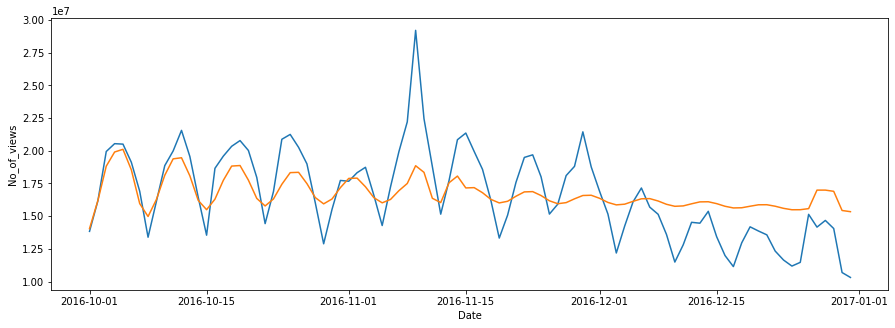

In [404]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_spanish.Date, y=test_spanish.No_of_views)
sns.lineplot(x=test_spanish.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [405]:
# Adding Exogenous variable campaign to train data frame
train_spanish['Campaign'] = exog['Campaign'][:train_spanish.shape[0]]
train_spanish.head()

Date  No_of_views  Campaign
0 2015-07-01   15280134.0         0
1 2015-07-02   14603567.0         0
2 2015-07-03   13431140.0         0
3 2015-07-04   12610062.0         0
4 2015-07-05   13712704.0         0

In [406]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

spanish_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(spanish_prophet, 'Campaign')
spanish_prophet.fit(train_spanish.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = spanish_prophet.make_future_dataframe(periods=len(test_spanish),freq="D")
future['Campaign'] = exog['Campaign']
forecast = spanish_prophet.predict(future)

18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing


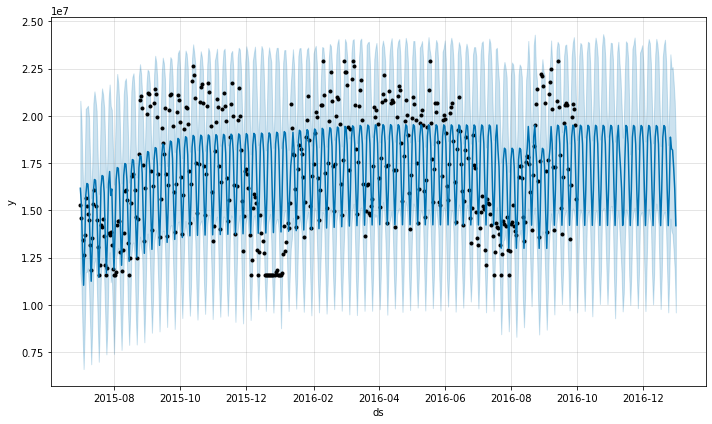

In [407]:
spanish_prophet.plot(forecast)
plt.show()

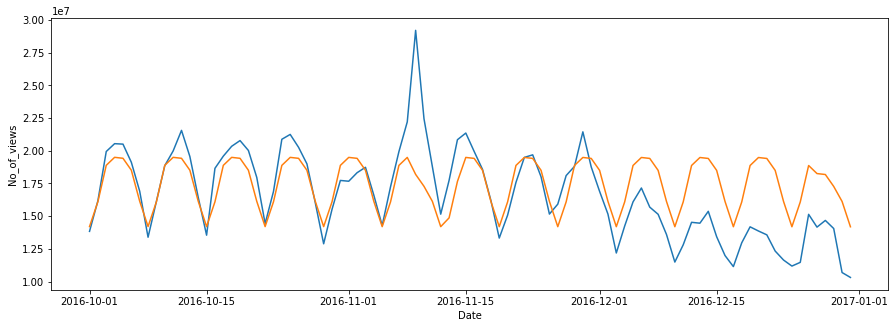

In [408]:
# I dont find any improvement here. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_spanish.Date, y=test_spanish.No_of_views)
sns.lineplot(x=test_spanish.Date, y=forecast.iloc[len(train_spanish):, :].yhat.values)
plt.show()

In [409]:
# We got 13.66% MAPE which is actually bad as compared to SARIMAX.
mean_absolute_percentage_error(test_spanish.No_of_views, forecast.iloc[len(train_spanish):, :].yhat)*100

13.664899334087051

###  Mixed(MISC) language time series

In [410]:
# We do not know if the columns are sorted left to right
df_mixed = df_mixed.reindex(sorted(df_mixed.columns), axis=1)
df_mixed.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
19611         NaN         NaN         NaN         NaN         NaN         NaN   
19612         NaN         NaN         NaN         NaN         NaN         NaN   
19613         NaN         NaN         NaN         NaN         NaN         NaN   
19614       528.0       587.0       634.0       483.0       510.0       559.0   
19615        37.0        38.0        46.0        41.0        79.0        91.0   

       2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
19611         NaN         NaN         NaN         NaN  ...        17.0   
19612         NaN         NaN         NaN         NaN  ...        91.0   
19613         NaN         NaN         NaN         NaN  ...        32.0   
19614       625.0       594.0       565.0       700.0  ...       479.0   
19615       100.0        54.0        43.0        60.0  ...        55.0   

       2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
19611        18.0        11.0        15.0        11.0        15.0        10.0   
19612        50.0        47.0        40.0        31.0        61.0        52.0   
19613        45.0        41.0        17.0        21.0        52.0        48.0   
19614       317.0       234.0       598.0       283.0       399.0       334.0   
19615        37.0        23.0       387.0        35.0        38.0        38.0   

       2016-12-29  2016-12-30  2016-12-31  
19611        14.0         7.0        12.0  
19612        43.0       100.0        73.0  
19613        32.0        41.0        19.0  
19614       351.0       358.0       275.0  
19615        28.0        45.0        41.0  

[5 rows x 550 columns]

In [411]:
df_mixed.shape

(13551, 550)

In [412]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_mixed.columns[0], df_mixed.columns[-1]

('2015-07-01', '2016-12-31')

In [413]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_mixed.columns[-1]) - pd.to_datetime(df_mixed.columns[0])).split()[0])+1

550

In [414]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_mixed.isna().sum(axis=1)

19611    408
19612    414
19613    519
19614      0
19615      0
        ... 
82981    433
82982    439
82983    550
82984    550
82985    550
Length: 13551, dtype: int64

In [415]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_mixed.isna().sum(axis=1)[df_mixed.isna().sum(axis=1)/550 >= 0.05].index
df_mixed.drop(nan_indices, inplace=True)
df_mixed.isna().sum(axis=1)[df_mixed.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [416]:
df_mixed.shape

(8281, 550)

In [417]:
# Filling the missing values page wise using the bfill technique. 
df_mixed.fillna(method='bfill', axis=1, inplace=True)

In [418]:
# Getting the sum of views of all the pages combined for each date.
df_mixed = df_mixed.sum().to_frame(name='No_of_views').rename_axis('Date')
df_mixed = df_mixed.reset_index()
df_mixed['Date'] = pd.to_datetime(df_mixed.Date) # Converting Date column to date_time 

In [419]:
# We donot have any missing values
df_mixed.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [420]:
df_mixed.groupby([df_mixed.Date.dt.year, df_mixed.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [421]:
df_mixed.groupby([df_mixed.Date.dt.year, df_mixed.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [422]:
# Seperating the last 3 months of the data sets to use it for testing. 
# Anything after 2016-08-01 will be kept for testing. 
train_mixed = df_mixed.set_index('Date').loc['2015-07-01':'2016-09-30',:].reset_index()
test_mixed = df_mixed.set_index('Date').loc['2016-10-01':,:].reset_index()

In [423]:
train_mixed.shape, test_mixed.shape

((458, 2), (92, 2))

<AxesSubplot:xlabel='Date'>

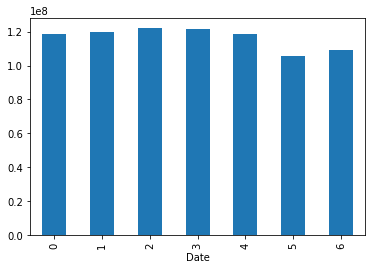

In [424]:
# Comparing total No of views on weekly basis.
# Views on Tuesdays are higher compared to other days of the week. 
train_mixed.groupby(train_mixed.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [426]:
# Getting the first date of every month and also the sundays of every week.
tuesdays = train_mixed[(train_mixed.Date.dt.dayofweek == 2)].Date.values
month_1st_dates =  train_mixed[(train_mixed.Date.dt.day == 1)].Date.values

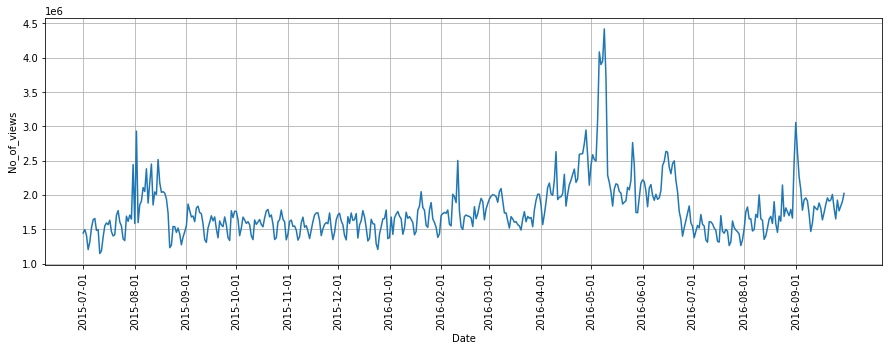

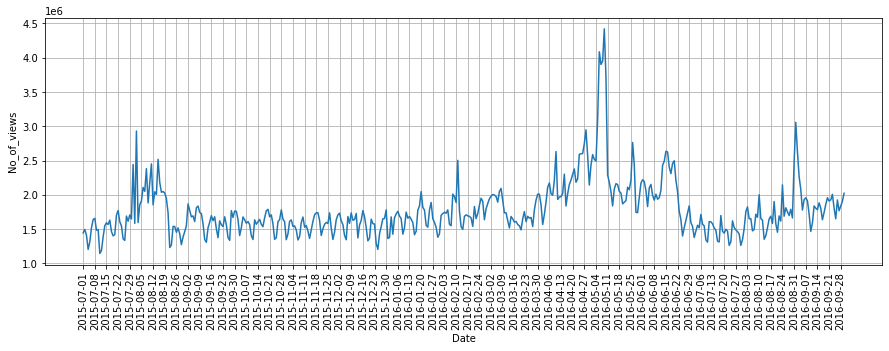

In [427]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(train_mixed.Date, train_mixed.No_of_views)
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(train_mixed.Date, train_mixed.No_of_views)
plt.xticks(tuesdays, rotation='90')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on tuesdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [429]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_mixed.No_of_views)
# P-val = 0.009 which is lesser than 0.05.
# We reject null hypothesis. Hence, time series is stationary.

(-3.4443639746376205,
 0.009536334109003917,
 6,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 12065.864759352015)

#### Time series decomposition

In [430]:
from statsmodels.tsa.seasonal import seasonal_decompose

mixed_decomp = seasonal_decompose(train_mixed.set_index('Date'), two_sided=False)

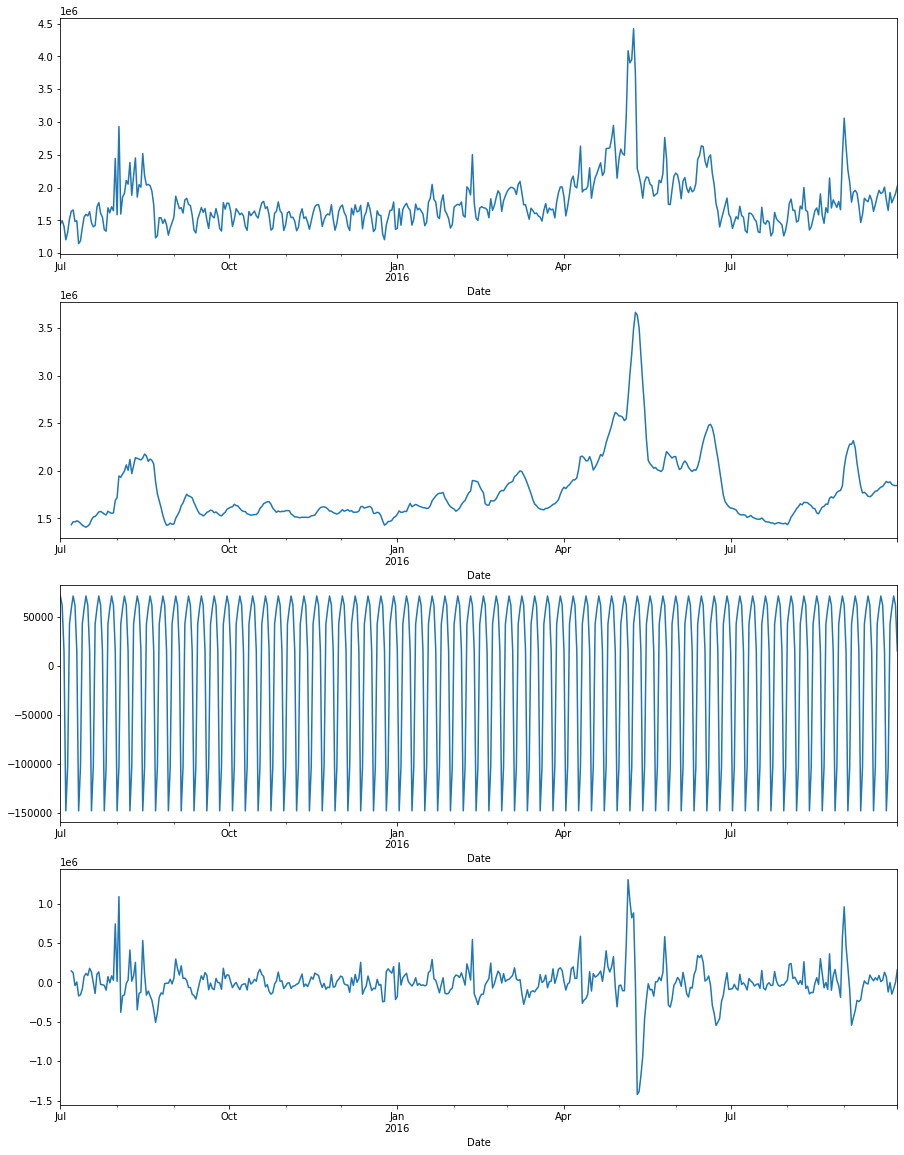

In [431]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
mixed_decomp.observed.plot()
plt.subplot(4,1,2)
mixed_decomp.trend.plot()
plt.subplot(4,1,3)
mixed_decomp.seasonal.plot()
plt.subplot(4,1,4)
mixed_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [432]:
mixed_decomp.resid

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
                  ...      
2016-09-26     -1538.259179
2016-09-27   -147825.039982
2016-09-28    -81594.257565
2016-09-29      -599.101521
2016-09-30    162183.527051
Name: resid, Length: 458, dtype: float64

In [434]:
from statsmodels.tsa.stattools import adfuller

adfuller(mixed_decomp.resid[6:])
# P-val = 5.197156430288151e-20 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-11.046850841244607,
 5.197156430288151e-20,
 4,
 447,
 {'1%': -3.4450642060791097,
  '5%': -2.868027634065253,
  '10%': -2.5702256691640515},
 11725.98223676464)

#### Stationary conversion - Detrending

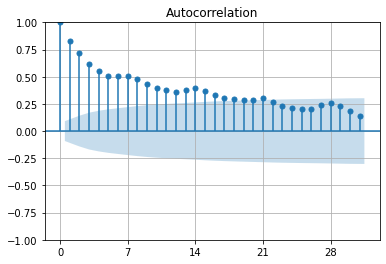

In [435]:
# I can see some good amount of correlation (Coeff > 0.5).  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_mixed.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [436]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_mixed.No_of_views.diff()
detrend

0           NaN
1       50315.0
2      -84098.0
3     -207316.0
4      111338.0
         ...   
453    274519.0
454   -157288.0
455     68429.0
456     68532.0
457    118276.0
Name: No_of_views, Length: 458, dtype: float64

In [437]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 6.804774920446968e-15 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-8.993172533669386,
 6.804774920446968e-15,
 11,
 445,
 {'1%': -3.4451307246616514,
  '5%': -2.86805689169311,
  '10%': -2.570241263729327},
 12048.685310200884)

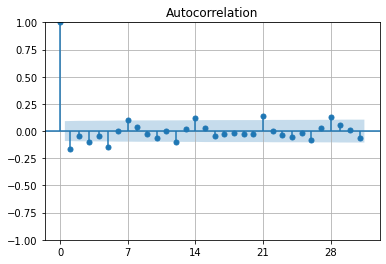

In [438]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

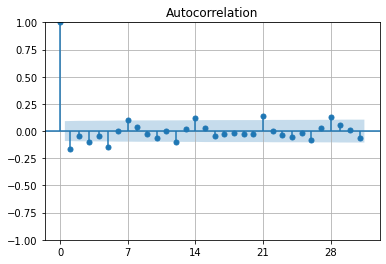

In [439]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

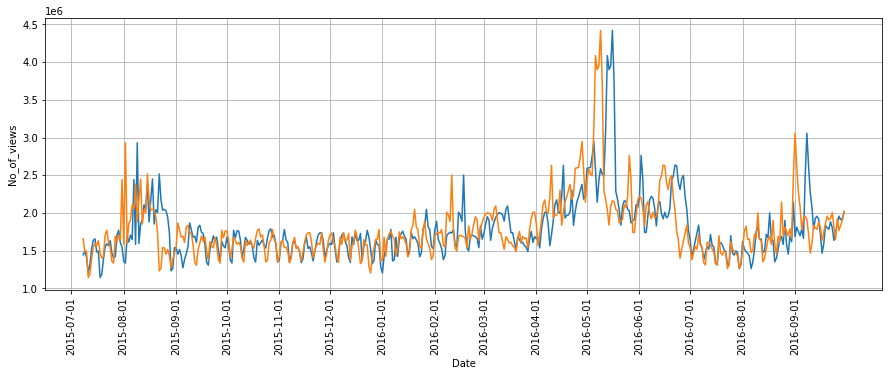

In [440]:
# We can see that almost all the seasonal peaks coincide.
plt.figure(figsize=(15,5))
sns.lineplot(train_mixed.Date, train_mixed.No_of_views.shift(7))
sns.lineplot(train_mixed.Date, train_mixed.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='90')
plt.grid()
plt.show()

In [441]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8    -223918.0
9      94458.0
10   -141460.0
Name: No_of_views, dtype: float64

In [442]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val =  3.912300471650472e-18 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-10.274968800568962,
 3.912300471650472e-18,
 14,
 435,
 {'1%': -3.4454725477848998,
  '5%': -2.8682072297316794,
  '10%': -2.570321396485665},
 11956.297284282278)

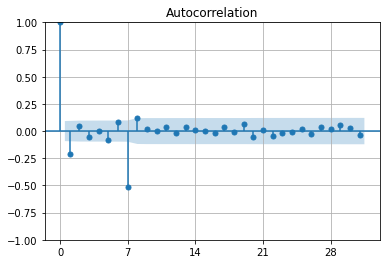

In [443]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

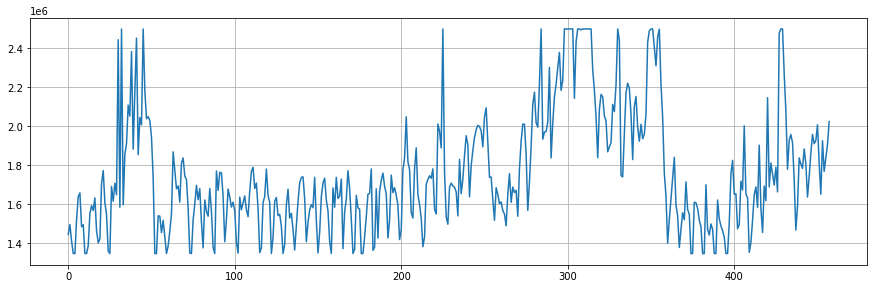

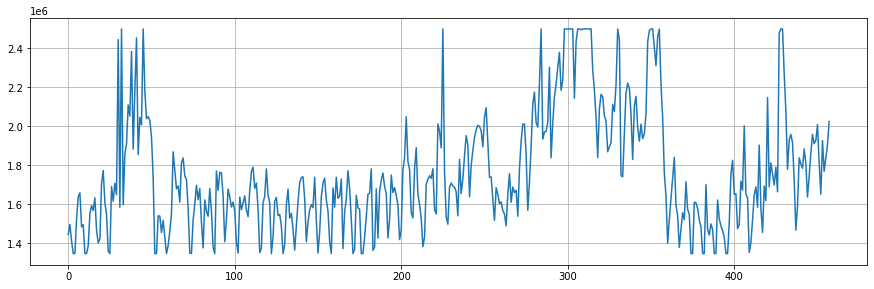

In [451]:
# Clipping the the top 5% and bottom 5% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_mixed.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_mixed.No_of_views.clip(upper=train_mixed.No_of_views.quantile(0.95), 
                               lower=train_mixed.No_of_views.quantile(0.05)).plot(kind='line')
plt.grid()
plt.show()

In [448]:
# Clipping the anamolies or outliers. 
train_mixed['No_of_views'] = train_mixed.No_of_views.clip(upper=train_mixed.No_of_views.quantile(0.95), 
                               lower=train_mixed.No_of_views.quantile(0.05))

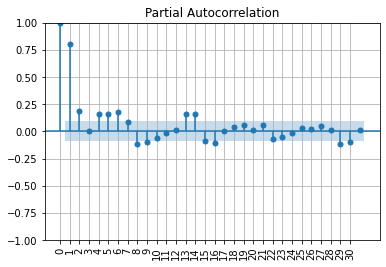

In [452]:
# I can see that some of thelags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 6 lags as hyperparameters p.
plot_pacf(train_mixed.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

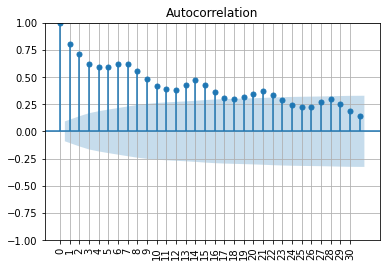

In [453]:
# I can see that some of the lines appear to be a bit significant(Coeff > 0.5) as per the confidence intervals. 
#  I will take only the first 8 lags as hyperparameters q.
plot_acf(train_mixed.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='90')
plt.grid()
plt.show()

In [456]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 or 2.
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,7), 'q':np.arange(1,9)}))

arima_mapes = []

for i in range(len(param_grid)):
    mixed_arima = SARIMAX(train_mixed.No_of_views, 
                             order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_mixed.No_of_views, 
                                                      mixed_arima.forecast(len(test_mixed)))*100)

In [457]:
# For order = (4,1,2), I could get the MAPE as 8.68%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 4, 'q': 2}, 8.685403220650356)

> -  Best MAPE with ARIMAX for test set is  8.68%

In [458]:
# Retraining the model with the best params for the entire train set.
mixed_arima = SARIMAX(train_mixed.No_of_views, order=(4,1,2)).fit(disp=False)

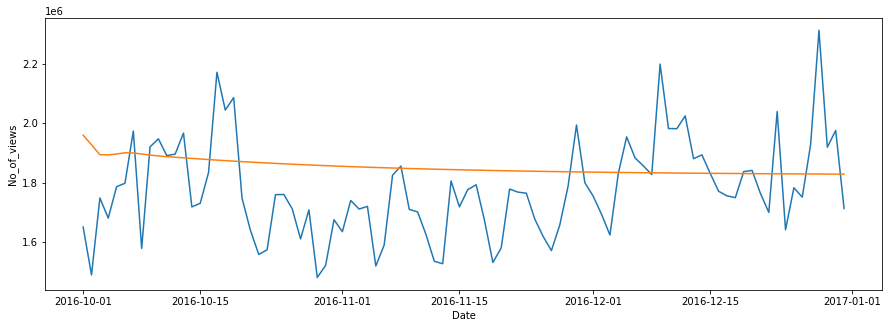

In [459]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_mixed.Date, y=test_mixed.No_of_views)
sns.lineplot(x=test_mixed.Date, y=mixed_arima.forecast(len(test_mixed)).values)
plt.show()

#### Modelling - SARIMAX

In [460]:
exog = pd.read_csv('Exog_Campaign_eng.csv').rename({'Exog':'Campaign'}, axis=1)
exog.head()

Campaign
0         0
1         0
2         0
3         0
4         0

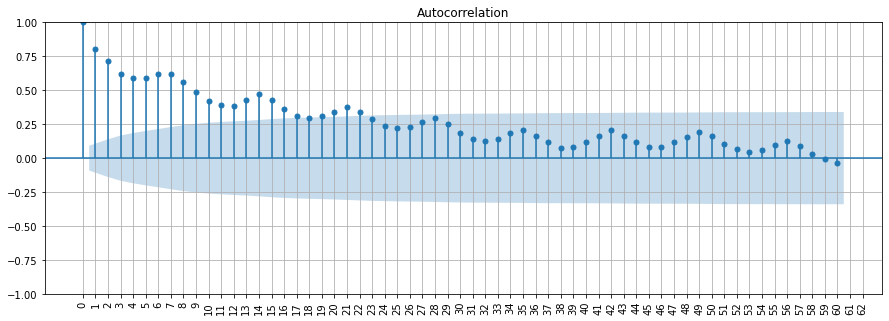

In [461]:
# Some of the seasonal lines (Multiples of 7) appear to be bit as per the confidence intervals. 
# From this plot, I will take the first 3 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_mixed.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

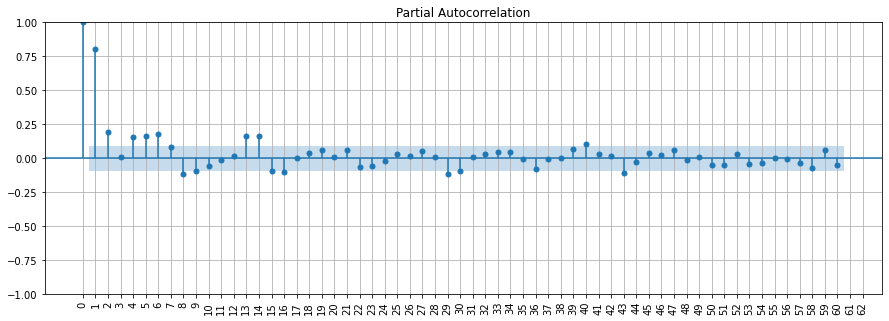

In [462]:
# From this plot, I will take only the first 2 seasonality lags as hyperparameters for P.
# I dont see any lag being significant but still taking 2. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_mixed.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='90')
plt.grid()
plt.show()

In [463]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, values can only be less than 6(As seasonal lags start coinciding with non-seasonal from 7)
# For AR-Seasonality an MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2], 'Q':[1,2,3]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    mixed_sarimax = SARIMAX(train_mixed.No_of_views,
                            exog = exog.Campaign[:len(train_mixed)], 
                            order=(4, 1, 2), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = mixed_sarimax.forecast(steps = len(test_mixed), 
                                             exog = exog.Campaign[len(train_mixed):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_mixed.No_of_views, test_forecast)*100)

In [464]:
# For params (4,1,2) and (1,1,1,7), I could get an MAPE as 13.42% which is actually a bad score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 1, 'Q': 2}, 13.42461794040832)

> -  Best MAPE with SARIMAX for test set is 13.42%

In [466]:
# Retraining the sarimax model with the best params
mixed_sarimax = SARIMAX(train_mixed.No_of_views, 
                          order=(4,1,2), 
                          seasonality_order=(1, 1, 2, 7), 
                          exog = exog.Campaign[:len(train_mixed)]).fit(disp=False)
test_forecast = mixed_sarimax.forecast(steps = len(test_mixed), 
                                             exog = exog.Campaign[len(train_mixed):].reset_index(drop=True))

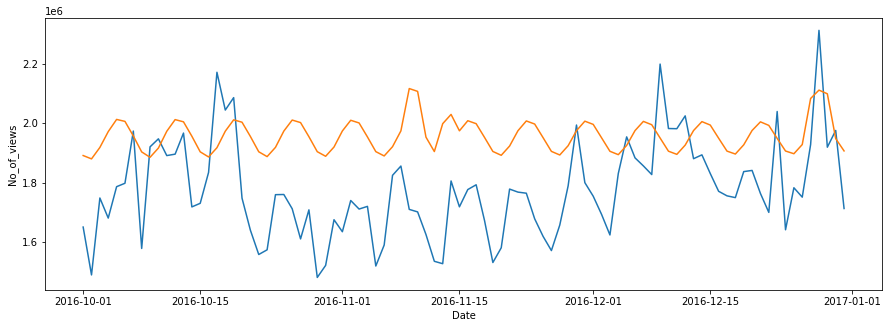

In [467]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_mixed.Date, y=test_mixed.No_of_views)
sns.lineplot(x=test_mixed.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [468]:
# Adding Exogenous variable campaign to train data frame
train_mixed['Campaign'] = exog['Campaign'][:train_mixed.shape[0]]
train_mixed.head()

Date  No_of_views  Campaign
0 2015-07-01   1445337.00         0
1 2015-07-02   1495652.00         0
2 2015-07-03   1411554.00         0
3 2015-07-04   1346962.65         0
4 2015-07-05   1346962.65         0

In [469]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

mixed_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(mixed_prophet, 'Campaign')
mixed_prophet.fit(train_mixed.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = mixed_prophet.make_future_dataframe(periods=len(test_mixed),freq="D")
future['Campaign'] = exog['Campaign']
forecast = mixed_prophet.predict(future)

19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing


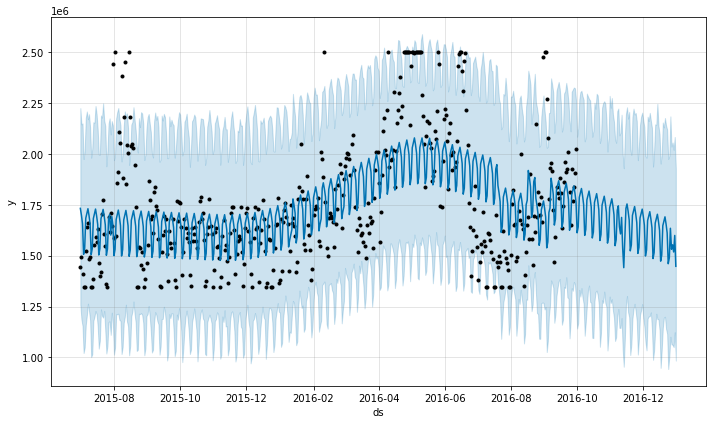

In [470]:
mixed_prophet.plot(forecast)
plt.show()

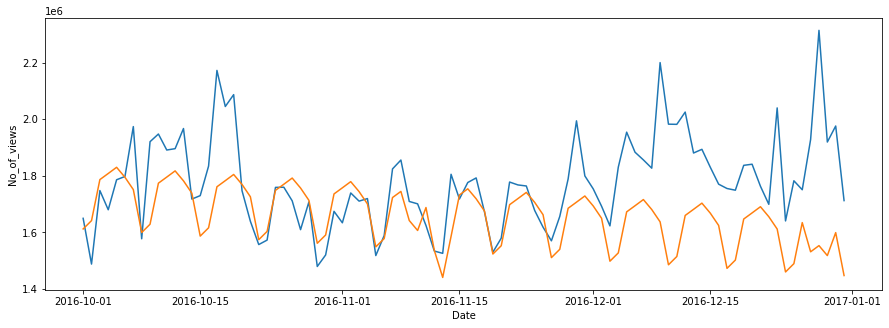

In [471]:
# I dont find any improvement here. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_mixed.Date, y=test_mixed.No_of_views)
sns.lineplot(x=test_mixed.Date, y=forecast.iloc[len(train_mixed):, :].yhat.values)
plt.show()

In [473]:
# We got 7.83% MAPE which is actually better than both SARIMAX and ARIMA. 
mean_absolute_percentage_error(test_mixed.No_of_views, forecast.iloc[len(train_mixed):, :].yhat)*100

7.837137106494644